In [7]:
!rm -rf ../mrvi_ibd/"

In [3]:
!ls /data/yosef3/users/can/mrvi_ibd/new_conda

%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

import torch
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)
mem = torch.cuda.mem_get_info()
mem[0]/mem[1]

scvi-v2
env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2
env: XLA_PYTHON_CLIENT_PREALLOCATE=false


/data/yosef3/users/can/conda/envs/ibd_penelope_new3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tesla V100-PCIE-32GB


0.9277332707713963

In [4]:
ls scvi-v2/src

ls: cannot access 'scvi-v2/src': No such file or directory


In [5]:
import pandas as pd
import glob
import os
import scanpy as sc
import numpy as np
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster, optimal_leaf_ordering
from scipy.spatial.distance import squareform
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, optimal_leaf_ordering
from scipy.spatial.distance import squareform
from tqdm import tqdm
import matplotlib.pyplot as plt
import contextlib
from matplotlib.backends.backend_pdf import PdfPages

In [6]:
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Prepare data

In [6]:
immune_aging = sc.read('/data/yosef3/users/can/immune_aging/doublet_removal/processing_results_newest/process_integration/All_filtered/All_filtered.unstim_cleanup.v2.h5ad')

Only considering the two last: ['.v2', '.h5ad'].
Only considering the two last: ['.v2', '.h5ad'].


In [7]:
immune_aging

AnnData object with n_obs × n_vars = 1368687 × 36587
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'library', 'donor', 'site', 'age', 'sex', 'sample', 'chemistry', 'n_proteins', '_scvi_batch', '_scvi_labels', 'overclustering_percolate', 'sum_percolation_score', 'tissue', 'batch', 'bcr_library_id', 'tcr_library_id'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'hsp', 'is_highly_variable_gene_batch_key_donor_id', 'is_highly_variable_gene_batch_key_donor_id+tissue'
    uns: 'site_colors', 'tissue_colors'
    obsm: 'BCR_IR', 'TCR_IR', 'X_pca', 'X_scvi_integrated_batch_key_donor_id', 'X_scvi_integrated_batch_key_donor_id+tissue', 'X_umap_pca', 'X_umap_scvi_integrated_batch_key_donor_id', 'X_umap_scvi_integrated_batch_key_donor_id+tissue', 'bh_pval', 'celltypist', 'celltypist_probability_matrix.Immune_All_High', 'celltypist_probability_matrix.Immune_All_Low', 'clustering', 'donor_level_obs', 'hashtag', 'median_cluster_score', 'protein_expression', 'protein_expression_C

In [ ]:
celltypes_steven = pd.read_parquet('/data/yosef3/users/can/immune_aging/mrvi_analysis/analysis_classification_25_knn.pqt', engine='pyarrow')
immune_aging = immune_aging[celltypes_steven.index]
immune_aging.obs['celltypes_steven'] = celltypes_steven.loc[immune_aging.obs_names]

celltypes_steven_old = pd.read_parquet('/data/yosef3/users/can/immune_aging/mrvi_analysis/analysis_classification_knn.pqt', engine='pyarrow')
immune_aging = immune_aging[celltypes_steven_old.index]
immune_aging.obs['celltypes_steven_old'] = celltypes_steven_old.loc[immune_aging.obs_names]

dan_correction = pd.read_csv('/data/yosef3/users/can/immune_aging/mrvi_analysis/NY_DR_disagreement_annotation.csv', index_col=0)
immune_aging.obs['dan_correction'] = immune_aging.obs['celltypes_steven'].astype(str)
immune_aging.obs.loc[dan_correction.index, 'dan_correction'] = dan_correction['DR_NY_annotation']

celltypes_groups = pd.read_parquet('/data/yosef3/users/can/immune_aging/mrvi_analysis/schpf_groups.pqt', engine='pyarrow')
celltypes_groups.head()
immune_aging.obs['schpf_groups'] = celltypes_groups

fine_annotation = pd.read_csv('/data/yosef3/users/can/immune_aging/mrvi_analysis/NY_DR_annotation_7thJuly2023.csv', index_col=0)
immune_aging.obs['fine_celltypes'] = fine_annotation

/tmp/ipykernel_944300/1913350116.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  immune_aging.obs['celltypes_steven'] = celltypes_steven.loc[immune_aging.obs_names]


In [ ]:
schpf_groups_to_mrvi = {
    'cd4': 'CD4+ Tcell',
    'cd8': 'CD8+ Tcell',
    'b': 'B cell',
    'macrophage': 'Myeloid',
    'nk': 'NK ILC',
    'monocyte_classical': 'Myeloid',
    'plasma': 'B cell',
    'mast_cell': 'Mast Cell',
    'ilc': 'NK ILC',
    'nk_ilc_precursor': 'NK ILC',
    'monocyte_nonclassical': 'Myeloid',
    'erythroid': None,
    'progenitor': None,
    'dc': 'Myeloid',
    'disagreement': None,
    'pdc': 'Myeloid'
}

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
immune_aging.layers['normalized_counts'] = immune_aging.X.copy()
sc.pp.normalize_total(immune_aging, layer='normalized_counts', target_sum=1e4)

In [ ]:
immune_aging_sub = immune_aging[~immune_aging.obs['dan_correction'].str.contains('lqe')]
immune_aging_sub = immune_aging_sub[immune_aging_sub.obs['celltypes_steven'].dropna().index]
immune_aging_sub = immune_aging_sub[~immune_aging_sub.obs['dan_correction'].isin(['epithelial', 'endothelial', 'fibroblast'])]
immune_aging_sub = immune_aging_sub[~immune_aging_sub.obs['fine_celltypes'].astype(str).str.contains('prolif')]
immune_aging_other = immune_aging[list(set(immune_aging.obs_names) - set(immune_aging_sub.obs_names))]
immune_aging_sub = immune_aging_sub[~immune_aging_sub.obs['tissue'].isin(['THY'])]
immune_aging_sub = immune_aging_sub[~immune_aging_sub.obs['tissue'].isin(['COLEPI'])]
immune_aging_sub = immune_aging_sub[~immune_aging_sub.obs['tissue'].isin(['COLLP'])]
immune_aging_sub = immune_aging_sub[~immune_aging_sub.obs['tissue'].isin(['LIV'])]
immune_aging_sub = immune_aging_sub[~immune_aging_sub.obs['tissue'].isin(['SKN'])]

In [ ]:
immune_aging_sub.var['enrichment_target'] = np.squeeze(np.asarray(
    immune_aging_sub.layers['normalized_counts'].mean(0) / (1e-6 + immune_aging_other.layers['normalized_counts'].mean(0))))

In [ ]:
immune_aging_sub.var

In [ ]:
immune_aging_sub.var.loc[['CCL5', 'COL1A1', 'EPCAM'], 'enrichment_target']

In [ ]:
tissue_groups_to_tissue = {
    'LLN': 'LN',
    'SPL': 'SPL',
    'BMA': 'BMA',
    'MLN': 'LN',
    'LNG': 'RESP',
    'BLO': 'BLO',
    'JEJEPI': 'GUT',
    'JEJLP': 'GUT',
    'BAL': 'RESP',
    'ILN': 'LN'
}
immune_aging_sub.obs['tissue_groups'] = [tissue_groups_to_tissue[i] for i in immune_aging_sub.obs['tissue']]
immune_aging_sub.obs['tissue_groups'].value_counts()

LN      423192
RESP    208919
GUT     194017
SPL     178355
BMA     140174
BLO     110702
Name: tissue_groups, dtype: int64

In [61]:
immune_aging_sub.obs['mrvi_groups'] = [schpf_groups_to_mrvi[i] for i in immune_aging_sub.obs['schpf_groups']]
immune_aging_sub = immune_aging_sub[~pd.isna(immune_aging_sub.obs['mrvi_groups'])]
immune_aging_sub.obs['mrvi_groups'].value_counts()

CD4+ Tcell    357126
B cell        271686
CD8+ Tcell    247158
Myeloid       223513
NK ILC        125118
Mast Cell      16752
Name: mrvi_groups, dtype: int64

In [74]:
immune_aging_sub.var['gene_names'] = immune_aging_sub.var_names
whitelist_genes = pd.read_csv('/data/yosef3/users/can/immune_aging/mrvi_analysis/scHPF_genes.txt', sep='\t', index_col=1, header=None)
whitelist_genes

,0
1,
OR4F5,ENSG00000186092.6
OR4F29,ENSG00000284733.1
OR4F16,ENSG00000284662.1
SAMD11,ENSG00000187634.11
NOC2L,ENSG00000188976.10
...,...
BPY2C,ENSG00000185894.8
CDY1,ENSG00000172288.7
SPRY3,ENSG00000168939.11_PAR_Y


In [63]:
immune_aging_sub.obs['donor_tissue'] = immune_aging_sub.obs.donor.astype(str) + "_" + immune_aging_sub.obs.tissue.astype(str)
immune_aging_sub.obs['donor_tissue'] = immune_aging_sub.obs['donor_tissue'].astype("category")

immune_aging_sub.obs['donor_tissue_annotation'] = immune_aging_sub.obs.donor_tissue.astype(str) + "_" + immune_aging_sub.obs.mrvi_groups.astype(str)
immune_aging_sub.obs['donor_tissue_annotation'] = immune_aging_sub.obs['donor_tissue_annotation'].astype("category")

immune_aging_sub.obs['donor_tissue_groups'] = immune_aging_sub.obs.donor.astype(str) + "_" + immune_aging_sub.obs.tissue_groups.astype(str)
immune_aging_sub.obs['donor_tissue_groups'] = immune_aging_sub.obs['donor_tissue_groups'].astype("category")

immune_aging_sub.obs['donor_tissue_groups_coarse'] = immune_aging_sub.obs.tissue_groups.astype(str) + "_" + immune_aging_sub.obs.mrvi_groups.astype(str)
immune_aging_sub.obs['donor_tissue_groups_coarse'] = immune_aging_sub.obs['donor_tissue_groups_coarse'].astype("category")

immune_aging_sub.obs['donor_tissue_groups_fine'] = immune_aging_sub.obs.tissue_groups.astype(str) + "_" + immune_aging_sub.obs.celltypes_steven.astype(str)
immune_aging_sub.obs['donor_tissue_groups_fine'] = immune_aging_sub.obs['donor_tissue_groups_fine'].astype("category")

In [69]:
sc.pp.filter_genes(immune_aging_sub, min_counts=30)

In [77]:
immune_aging_sub = immune_aging_sub[:, np.intersect1d(immune_aging_sub.var_names, whitelist_genes.index)]
immune_aging_sub = immune_aging_sub[:, immune_aging_sub.var['enrichment_target']>0.1]

In [78]:
immune_aging_sub

View of AnnData object with n_obs × n_vars = 1241353 × 14798
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'library', 'donor', 'site', 'age', 'sex', 'sample', 'chemistry', 'n_proteins', '_scvi_batch', '_scvi_labels', 'overclustering_percolate', 'sum_percolation_score', 'tissue', 'batch', 'bcr_library_id', 'tcr_library_id', 'celltypes_steven', 'celltypes_steven_old', 'dan_correction', 'schpf_groups', 'fine_celltypes', 'tissue_groups', 'mrvi_groups', 'donor_tissue', 'donor_tissue_annotation', 'donor_tissue_groups', 'donor_tissue_groups_coarse', 'donor_tissue_groups_fine'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'hsp', 'is_highly_variable_gene_batch_key_donor_id', 'is_highly_variable_gene_batch_key_donor_id+tissue', 'enrichment_target', 'gene_names', 'n_counts'
    obsm: 'BCR_IR', 'TCR_IR', 'X_pca', 'X_scvi_integrated_batch_key_donor_id', 'X_scvi_integrated_batch_key_donor_id+tissue', 'X_umap_pca', 'X_umap_scvi_integrated_batch_key_donor_id', 'X_umap_scvi_integ

In [79]:
immune_aging_sub.obs[['cmv', 'ebv', 'DCD/DBD', 'height', 'bmi', 'smoking_period']] = immune_aging_sub.obsm['donor_level_obs'][[
    'cmv', 'ebv', 'DCD/DBD', 'height', 'bmi', 'smoking_period']]
immune_aging_sub.obs[['cmv', 'donor']] = immune_aging_sub.obs[['cmv', 'donor']].astype(str).replace({'nan': 'negative'})

/tmp/ipykernel_842315/2941138356.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  immune_aging_sub.obs[['cmv', 'ebv', 'DCD/DBD', 'height', 'bmi', 'smoking_period']] = immune_aging_sub.obsm['donor_level_obs'][[


In [80]:
immune_aging_sub.obs['age_int'] = [int(i.split('-')[0]) for i in immune_aging_sub.obs['age']]
immune_aging_sub.obs['age_group'] = ['<40' if i<40 else '>40' for i in immune_aging_sub.obs['age_int']]
immune_aging_sub.obs['age_group'] = immune_aging_sub.obs['age_group'].astype('category')

In [82]:
immune_aging_sub.write('preprocessed_de_immuneaging4.h5ad')

In [173]:
immune_aging_sub_small = immune_aging_sub.copy()
del immune_aging_sub_small.layers
immune_aging_sub_small

AnnData object with n_obs × n_vars = 1241353 × 14798
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'library', 'donor', 'site', 'age', 'sex', 'sample', 'chemistry', 'n_proteins', '_scvi_batch', '_scvi_labels', 'overclustering_percolate', 'sum_percolation_score', 'tissue', 'batch', 'bcr_library_id', 'tcr_library_id', 'celltypes_steven', 'celltypes_steven_old', 'dan_correction', 'schpf_groups', 'fine_celltypes', 'tissue_groups', 'mrvi_groups', 'donor_tissue', 'donor_tissue_annotation', 'donor_tissue_groups', 'donor_tissue_groups_coarse', 'donor_tissue_groups_fine', 'cmv', 'ebv', 'DCD/DBD', 'height', 'bmi', 'smoking_period', 'age_int', 'age_group'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'hsp', 'is_highly_variable_gene_batch_key_donor_id', 'is_highly_variable_gene_batch_key_donor_id+tissue', 'enrichment_target', 'gene_names', 'n_counts'
    obsm: 'BCR_IR', 'TCR_IR', 'X_pca', 'X_scvi_integrated_batch_key_donor_id', 'X_scvi_integrated_batch_key_donor_id+tissue', '

In [174]:
immune_aging_sub_small.write('preprocessed_de_immuneaging4_small.h5ad')

In [ ]:
immune_aging_sub.write('preprocessed_de_immuneaging4.h5ad')

# Tissue DE

In [751]:
immune_aging_sub = sc.read('preprocessed_de_immuneaging4.h5ad')

In [752]:
immune_aging_sub.layers

Layers with keys: normalized_counts

In [753]:
import upsetplot
from upsetplot import UpSet

In [754]:
tissue_groups = ['resp', 'ln', 'gut', 'bma', 'spl']

In [ ]:
df = pd.DataFrame()
for tissue_group in tissue_groups:
    df_tissue = pd.read_csv(f"results_dreamlet/{tissue_group}_vs_blood_random.csv")
    df_tissue["tissue_groups"] = tissue_group
    df = pd.concat([df, df_tissue], axis=0)
df = df.loc[~df['assay'].str.contains('Mast')]

In [846]:
df_fine = pd.DataFrame()
for tissue_group in tissue_groups:
    df_tissue = pd.read_csv(f"results_dreamlet_fine/{tissue_group}_vs_blood_random.csv")
    df_tissue["tissue_groups"] = tissue_group
    df_fine = pd.concat([df_fine, df_tissue], axis=0)
df_fine = df_fine.loc[~df_fine['assay'].str.contains('Mast')]

In [848]:
df_fine.to_parquet('de_results_tissue_fine.gzip', compression='gzip') 

In [756]:
logfc = 1
pval = 0.05
mask_genes = (df["adj.P.Val"] < 0.05) & (df["logFC"] > logfc)
genes = df[mask_genes].ID.unique()
len(genes)

5703

,Unnamed: 0,assay,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B,z.std,tissue_groups
0,1,Myeloid,CNOT8,-1.566465,5.420204,-31.486836,6.421100e-68,2.896846e-63,144.591002,-17.414353,resp
1,2,Myeloid,ENOSF1,3.146895,3.998358,31.219918,1.037069e-67,2.896846e-63,143.981192,17.386892,resp
2,3,Myeloid,DAB2,4.445670,6.415354,31.239416,1.580616e-67,2.943423e-63,143.586782,17.362718,resp
3,4,Myeloid,ACP5,5.418739,6.972788,30.161745,1.524493e-65,2.129183e-61,139.174197,17.098433,resp
4,5,Myeloid,TMEM251,2.909526,4.468946,28.989232,1.521228e-63,1.699698e-59,134.449367,16.828013,resp
...,...,...,...,...,...,...,...,...,...,...,...
55861,55862,B cell,TMCC3,-0.000065,1.833479,-0.000267,9.997870e-01,9.998586e-01,-6.467191,-0.000267,spl
55862,55863,B cell,UBE2N,0.000022,6.509853,0.000209,9.998336e-01,9.998873e-01,-6.746584,0.000209,spl
55863,55864,Myeloid,SLC30A4,-0.000080,0.790255,-0.000152,9.998786e-01,9.999081e-01,-6.334314,-0.000152,spl
55864,55865,Myeloid,MME,0.000126,0.874031,0.000138,9.998902e-01,9.999081e-01,-6.358271,0.000138,spl


In [758]:
df.loc[mask_genes, 'assay'].value_counts()

Myeloid       6445
B cell        4559
CD4+ Tcell    3998
NK ILC        2518
CD8+ Tcell    2356
Name: assay, dtype: int64

In [759]:
#collect genes for each tissue x celltype
genes_comparison = dict()
genes_comparison_group = dict()
genes_all = []
percent_min = 0.1
genes_plot = dict()
subsets_analysis = list(df['assay'].unique())

In [760]:
subsets_analysis

['Myeloid', 'CD4+ Tcell', 'NK ILC', 'CD8+ Tcell', 'B cell']

In [761]:
for group in tissue_groups:
    genes_comparison_group = dict()
    group_upper = group.upper()
    for celltype in subsets_analysis:
        print(group_upper, celltype)
        mask_group_celltype = (df["adj.P.Val"] < 0.05) & (df["logFC"] > logfc) & (df['tissue_groups'] == group) & (df["assay"] == celltype)
        genes_group_celltype = df[mask_group_celltype].ID.unique()
        genes_group_celltype = np.intersect1d(genes_group_celltype, immune_aging_sub.var_names)

        ad = immune_aging_sub[(immune_aging_sub.obs['tissue_groups'] == group_upper) & (immune_aging_sub.obs["mrvi_groups"] == celltype), genes_group_celltype]
        
        genes_group_celltype = list(genes_group_celltype[(ad.X.mean(axis=0) > percent_min).tolist()[0]])
        genes_comparison[f"{group_upper}_{celltype}"] = genes_group_celltype
        genes_comparison_group[f"{celltype}"] = genes_group_celltype
        genes_all = genes_all + genes_group_celltype

    #upsetplot
    plot = upsetplot.from_contents(genes_comparison_group)
    data = upsetplot.query(plot, present=None).data
    data = data.reset_index()
    data = data.set_index("id")
    genes_plot[group_upper] = data[data.T.sum() > 2].index.tolist()

RESP Myeloid
RESP CD4+ Tcell
RESP NK ILC
RESP CD8+ Tcell
RESP B cell
LN Myeloid
LN CD4+ Tcell
LN NK ILC
LN CD8+ Tcell
LN B cell
GUT Myeloid
GUT CD4+ Tcell
GUT NK ILC
GUT CD8+ Tcell
GUT B cell
BMA Myeloid
BMA CD4+ Tcell
BMA NK ILC
BMA CD8+ Tcell
BMA B cell
SPL Myeloid
SPL CD4+ Tcell
SPL NK ILC
SPL CD8+ Tcell
SPL B cell


In [762]:
plot_all = upsetplot.from_contents(genes_comparison)
data_all = upsetplot.query(plot_all, present=None).data
data_all = data_all.reset_index()
data_all = data_all.set_index("id")
data_all_grouped = data_all.groupby(by=lambda x: x.split('_')[0], axis=1).sum()
genes_plot_all = data_all_grouped[(data_all_grouped > 0).sum(axis=1) > 1].index.tolist()
genes_plot_all

['AARS',
 'ABCC5',
 'ABCG1',
 'ABHD10',
 'ABHD12',
 'ABHD14A',
 'ABHD15',
 'ABHD5',
 'ABL2',
 'ACADM',
 'ACAT1',
 'ACOT13',
 'ACOT2',
 'ACOT7',
 'ACP2',
 'ACP5',
 'ACSF2',
 'ACTL6A',
 'ACY1',
 'ACYP1',
 'ADCK2',
 'ADCY3',
 'ADPRHL2',
 'ADRB2',
 'AFDN',
 'AGGF1',
 'AGPAT5',
 'AHI1',
 'AIFM2',
 'AIG1',
 'AK6',
 'AKAP1',
 'AKR1A1',
 'AKR1B1',
 'ALAS1',
 'ALDH1A1',
 'ALDH3A2',
 'ALG14',
 'ALG2',
 'ALG9',
 'ALKBH3',
 'ALOX5AP',
 'AMDHD2',
 'ANGEL1',
 'ANKRD22',
 'ANKRD28',
 'ANKRD37',
 'APEX2',
 'APIP',
 'APOC1',
 'APOC2',
 'APOE',
 'APOL1',
 'APOL2',
 'APOL4',
 'APOL6',
 'APOO',
 'AQP3',
 'ARHGAP10',
 'ARHGAP18',
 'ARHGAP22',
 'ARHGAP6',
 'ARID5B',
 'ARL1',
 'ARL13B',
 'ARL2',
 'ARL6IP6',
 'ARMC1',
 'ARPIN',
 'ARV1',
 'ASF1A',
 'ATF3',
 'ATG4C',
 'ATIC',
 'ATOX1',
 'ATP10A',
 'ATP1B1',
 'ATP2C1',
 'ATP6AP1',
 'ATP6V0D2',
 'ATP6V0E2',
 'ATP6V1C1',
 'AVPI1',
 'B3GNT5',
 'B3GNT7',
 'BACE1',
 'BAG3',
 'BATF3',
 'BCL2',
 'BCL2L1',
 'BET1',
 'BEX3',
 'BEX4',
 'BHLHE40',
 'BHLHE41',
 'BMP2K',
 'B

In [763]:
len(genes_plot_all)

1643

In [764]:
g = set([item for group in genes_plot for item in genes_plot[group]])

In [765]:
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = list(gene_symbols)
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((len(new_idx), len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=new_idx
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx, new_idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [766]:
immune_aging_sub

AnnData object with n_obs × n_vars = 1241353 × 14798
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'library', 'donor', 'site', 'age', 'sex', 'sample', 'chemistry', 'n_proteins', '_scvi_batch', '_scvi_labels', 'overclustering_percolate', 'sum_percolation_score', 'tissue', 'batch', 'bcr_library_id', 'tcr_library_id', 'celltypes_steven', 'celltypes_steven_old', 'dan_correction', 'schpf_groups', 'fine_celltypes', 'tissue_groups', 'mrvi_groups', 'donor_tissue', 'donor_tissue_annotation', 'donor_tissue_groups', 'donor_tissue_groups_coarse', 'donor_tissue_groups_fine', 'cmv', 'ebv', 'DCD/DBD', 'height', 'bmi', 'smoking_period', 'age_int', 'age_group'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'hsp', 'is_highly_variable_gene_batch_key_donor_id', 'is_highly_variable_gene_batch_key_donor_id+tissue', 'enrichment_target', 'gene_names', 'n_counts'
    obsm: 'BCR_IR', 'TCR_IR', 'X_pca', 'X_scvi_integrated_batch_key_donor_id', 'X_scvi_integrated_batch_key_donor_id+tissue', '

In [767]:
immune_aging_sub = immune_aging_sub[immune_aging_sub.obs['mrvi_groups']!='Mast Cell']
immune_aging_sub.obs['mrvi_groups'].value_counts()

CD4+ Tcell    357126
B cell        271686
CD8+ Tcell    247158
Myeloid       223513
NK ILC        125118
Name: mrvi_groups, dtype: int64

In [768]:
df_plot = grouped_obs_mean(immune_aging_sub, 'donor_tissue_groups_coarse', layer='normalized_counts', gene_symbols=genes_plot_all)
df_plot_normalized = df_plot.apply(lambda x: x/x.max(), axis=1)

In [769]:
df_plot_normalized = df_plot_normalized.reset_index().rename(columns={'index': 'gene_id'})
df_plot_export = df_plot.reset_index().rename(columns={'index': 'gene_id'})
df_plot_normalized

,gene_id,BLO_B cell,BLO_CD4+ Tcell,BLO_CD8+ Tcell,BLO_Myeloid,BLO_NK ILC,BMA_B cell,BMA_CD4+ Tcell,BMA_CD8+ Tcell,BMA_Myeloid,...,RESP_B cell,RESP_CD4+ Tcell,RESP_CD8+ Tcell,RESP_Myeloid,RESP_NK ILC,SPL_B cell,SPL_CD4+ Tcell,SPL_CD8+ Tcell,SPL_Myeloid,SPL_NK ILC
0,AARS,0.306232,0.231203,0.218333,0.131457,0.297134,0.700933,0.441555,0.442196,0.269047,...,1.000000,0.590903,0.524087,0.733840,0.464575,0.692934,0.608684,0.530495,0.385273,0.547882
1,ABCC5,0.149983,0.132312,0.212767,0.149978,0.298776,0.176642,0.200081,0.260922,0.324767,...,0.153704,0.169152,0.247835,0.411355,0.310413,0.240826,0.216040,0.275348,0.446422,0.326591
2,ABCG1,0.627744,0.148375,0.147453,0.065350,0.116914,0.398465,0.130890,0.180130,0.082078,...,0.380886,0.262025,0.222955,1.000000,0.161882,0.239261,0.177656,0.243773,0.168773,0.244143
3,ABHD10,0.623508,0.803720,0.794869,0.216271,0.790243,0.881196,0.763095,0.838738,0.410143,...,0.689153,0.617697,0.802600,0.453378,0.912461,0.836406,0.846980,0.947561,0.576678,0.861467
4,ABHD12,0.161333,0.148634,0.196953,0.352707,0.313101,0.152432,0.164559,0.215588,0.238677,...,0.179481,0.216720,0.268645,0.812261,0.354704,0.130797,0.169554,0.218836,0.251388,0.301513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,SH2D1A,0.010194,0.225759,0.362303,0.002397,0.514642,0.007272,0.364873,0.846416,0.002056,...,0.002667,0.494545,0.797251,0.001666,0.671006,0.006609,0.443648,1.000000,0.007774,0.817935
1639,YPEL1,0.075541,0.043284,0.180081,0.011407,0.839622,0.093425,0.155892,0.402010,0.019400,...,0.070819,0.095707,0.346807,0.012415,0.999319,0.071678,0.086749,0.414083,0.022446,1.000000
1640,HIST1H2BH,0.286111,0.182064,0.218267,0.122786,0.795210,0.812546,0.338138,0.617499,0.206670,...,0.835195,0.307209,0.529185,0.084147,0.680724,0.504901,0.334139,0.415774,0.177576,0.842649
1641,HIST1H4B,0.314496,0.210222,0.237904,0.032821,0.324391,0.767315,0.371031,0.463878,0.114765,...,0.678258,0.163164,0.282323,0.041009,0.236029,0.801651,0.591980,0.691942,0.195756,1.000000


In [770]:
df_plot_export

,gene_id,BLO_B cell,BLO_CD4+ Tcell,BLO_CD8+ Tcell,BLO_Myeloid,BLO_NK ILC,BMA_B cell,BMA_CD4+ Tcell,BMA_CD8+ Tcell,BMA_Myeloid,...,RESP_B cell,RESP_CD4+ Tcell,RESP_CD8+ Tcell,RESP_Myeloid,RESP_NK ILC,SPL_B cell,SPL_CD4+ Tcell,SPL_CD8+ Tcell,SPL_Myeloid,SPL_NK ILC
0,AARS,0.093239,0.070395,0.066476,0.040025,0.090469,0.213414,0.134441,0.134636,0.081917,...,0.304472,0.179913,0.159570,0.223434,0.141450,0.210979,0.185327,0.161521,0.117305,0.166815
1,ABCC5,0.062260,0.054924,0.088322,0.062258,0.124025,0.073326,0.083056,0.108312,0.134815,...,0.063804,0.070217,0.102879,0.170758,0.128856,0.099970,0.089681,0.114300,0.185315,0.135572
2,ABCG1,0.711085,0.168073,0.167030,0.074026,0.132436,0.451366,0.148268,0.204045,0.092975,...,0.431454,0.296812,0.252555,1.132763,0.183374,0.271026,0.201242,0.276137,0.191180,0.276556
3,ABHD10,0.171053,0.220493,0.218065,0.059332,0.216795,0.241748,0.209348,0.230099,0.112519,...,0.189062,0.169459,0.220185,0.124380,0.250325,0.229460,0.232361,0.259954,0.158206,0.236335
4,ABHD12,0.173637,0.159969,0.211973,0.379606,0.336980,0.164057,0.177109,0.232029,0.256880,...,0.193169,0.233248,0.289133,0.874208,0.381755,0.140772,0.182485,0.235525,0.270560,0.324508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,SH2D1A,0.014449,0.319981,0.513512,0.003397,0.729431,0.010307,0.517154,1.199673,0.002914,...,0.003781,0.700946,1.129989,0.002361,0.951055,0.009367,0.628808,1.417356,0.011019,1.159305
1639,YPEL1,0.056208,0.032206,0.133992,0.008487,0.624733,0.069514,0.115994,0.299121,0.014435,...,0.052694,0.071212,0.258047,0.009238,0.743558,0.053333,0.064547,0.308104,0.016701,0.744065
1640,HIST1H2BH,0.042748,0.027202,0.032611,0.018346,0.118813,0.121403,0.050521,0.092261,0.030879,...,0.124787,0.045900,0.079066,0.012572,0.101707,0.075437,0.049924,0.062121,0.026532,0.125901
1641,HIST1H4B,0.049044,0.032783,0.037100,0.005118,0.050587,0.119658,0.057860,0.072339,0.017897,...,0.105770,0.025445,0.044027,0.006395,0.036807,0.125013,0.092316,0.107904,0.030527,0.155944


In [771]:
df_plot_normalized = pd.melt(df_plot_normalized, id_vars=['gene_id'], value_vars=df_plot_normalized.columns[1:])
df_plot_export = pd.melt(df_plot_export, id_vars=['gene_id'], value_vars=df_plot.columns[1:])

In [772]:
from scipy import stats
import scipy

In [773]:
from scipy.cluster.hierarchy import linkage, to_tree, leaves_list
from scipy.cluster.hierarchy import fcluster
import PyComplexHeatmap as complex_heat

In [774]:
df_plot.columns

Index(['BLO_B cell', 'BLO_CD4+ Tcell', 'BLO_CD8+ Tcell', 'BLO_Myeloid',
       'BLO_NK ILC', 'BMA_B cell', 'BMA_CD4+ Tcell', 'BMA_CD8+ Tcell',
       'BMA_Myeloid', 'BMA_NK ILC', 'GUT_B cell', 'GUT_CD4+ Tcell',
       'GUT_CD8+ Tcell', 'GUT_Myeloid', 'GUT_NK ILC', 'LN_B cell',
       'LN_CD4+ Tcell', 'LN_CD8+ Tcell', 'LN_Myeloid', 'LN_NK ILC',
       'RESP_B cell', 'RESP_CD4+ Tcell', 'RESP_CD8+ Tcell', 'RESP_Myeloid',
       'RESP_NK ILC', 'SPL_B cell', 'SPL_CD4+ Tcell', 'SPL_CD8+ Tcell',
       'SPL_Myeloid', 'SPL_NK ILC'],
      dtype='object')

In [775]:
df['assay_group'] = df['tissue_groups'].astype(str).str.upper()  + '_' + df['assay'].astype(str)
df.index = df['assay_group']  + '_' + df['ID'].astype(str)

In [776]:
df_plot_export.index = df_plot_export['variable']  + '_' + df_plot_export['gene_id'].astype(str)
df_plot_normalized.index = df_plot_normalized['variable']  + '_' + df_plot_normalized['gene_id'].astype(str)
df_plot_export.head()

,gene_id,variable,value
BLO_CD4+ Tcell_AARS,AARS,BLO_CD4+ Tcell,0.070395
BLO_CD4+ Tcell_ABCC5,ABCC5,BLO_CD4+ Tcell,0.054924
BLO_CD4+ Tcell_ABCG1,ABCG1,BLO_CD4+ Tcell,0.168073
BLO_CD4+ Tcell_ABHD10,ABHD10,BLO_CD4+ Tcell,0.220493
BLO_CD4+ Tcell_ABHD12,ABHD12,BLO_CD4+ Tcell,0.159969


,gene_id,variable,value
BLO_CD4+ Tcell_A1BG,A1BG,BLO_CD4+ Tcell,0.419192
BLO_CD4+ Tcell_A3GALT2,A3GALT2,BLO_CD4+ Tcell,0.000165
BLO_CD4+ Tcell_A4GNT,A4GNT,BLO_CD4+ Tcell,0.000000
BLO_CD4+ Tcell_AAAS,AAAS,BLO_CD4+ Tcell,0.104032
BLO_CD4+ Tcell_AACS,AACS,BLO_CD4+ Tcell,0.036606
...,...,...,...
SPL_NK ILC_ZXDC,ZXDC,SPL_NK ILC,0.392197
SPL_NK ILC_ZYG11A,ZYG11A,SPL_NK ILC,0.000697
SPL_NK ILC_ZYG11B,ZYG11B,SPL_NK ILC,0.087597
SPL_NK ILC_ZYX,ZYX,SPL_NK ILC,0.984965


In [777]:
df['mean_expression'] = df_plot_export['value']
df['mean_expression_normalized'] = df_plot_normalized['value']

In [784]:
df

,Unnamed: 0,assay,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B,z.std,tissue_groups,assay_group,mean_expression,mean_expression_normalized,masked_logFC,masked_z,masked_z_expression
RESP_Myeloid_CNOT8,1,Myeloid,CNOT8,-1.566465,5.420204,-31.486836,6.421100e-68,2.896846e-63,144.591002,-17.414353,resp,RESP_Myeloid,NaN,NaN,-1.566465,-17.414353,-17.414353
RESP_Myeloid_ENOSF1,2,Myeloid,ENOSF1,3.146895,3.998358,31.219918,1.037069e-67,2.896846e-63,143.981192,17.386892,resp,RESP_Myeloid,0.435449,1.000000,3.146895,17.386892,17.386892
RESP_Myeloid_DAB2,3,Myeloid,DAB2,4.445670,6.415354,31.239416,1.580616e-67,2.943423e-63,143.586782,17.362718,resp,RESP_Myeloid,2.792898,0.820974,4.445670,17.362718,17.362718
RESP_Myeloid_ACP5,4,Myeloid,ACP5,5.418739,6.972788,30.161745,1.524493e-65,2.129183e-61,139.174197,17.098433,resp,RESP_Myeloid,10.602342,1.000000,5.418739,17.098433,17.098433
RESP_Myeloid_TMEM251,5,Myeloid,TMEM251,2.909526,4.468946,28.989232,1.521228e-63,1.699698e-59,134.449367,16.828013,resp,RESP_Myeloid,0.624077,1.000000,2.909526,16.828013,16.828013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SPL_B cell_TMCC3,55862,B cell,TMCC3,-0.000065,1.833479,-0.000267,9.997870e-01,9.998586e-01,-6.467191,-0.000267,spl,SPL_B cell,NaN,NaN,-0.000065,0.000000,-0.000267
SPL_B cell_UBE2N,55863,B cell,UBE2N,0.000022,6.509853,0.000209,9.998336e-01,9.998873e-01,-6.746584,0.000209,spl,SPL_B cell,NaN,NaN,0.000022,0.000000,0.000209
SPL_Myeloid_SLC30A4,55864,Myeloid,SLC30A4,-0.000080,0.790255,-0.000152,9.998786e-01,9.999081e-01,-6.334314,-0.000152,spl,SPL_Myeloid,NaN,NaN,-0.000080,0.000000,-0.000152
SPL_Myeloid_MME,55865,Myeloid,MME,0.000126,0.874031,0.000138,9.998902e-01,9.999081e-01,-6.358271,0.000138,spl,SPL_Myeloid,NaN,NaN,0.000126,0.000000,0.000138


In [785]:
df['masked_logFC'] = df['logFC']
df.loc[np.logical_or(df['adj.P.Val']>1., df['mean_expression_normalized']<0.05), 'masked_logFC'] = 0

df['masked_z'] = df['z.std']
df.loc[np.logical_or(df['adj.P.Val']>0.05, df['mean_expression_normalized']<1e-3), 'masked_z'] = 0

df['masked_z_expression'] = df['z.std']
df.loc[np.logical_or(df['adj.P.Val']>1., df['mean_expression_normalized']<0.05), 'masked_z_expression'] = 0

In [786]:
df['masked_logFC'].max()

11.0186482856324

In [787]:
#df.to_parquet('de_results_tissue_vs_.gzip', compression='gzip') 

In [813]:
clustering

,clusters,subclusters
AARS,5,3.0
ABCC5,3,2.0
ABCG1,3,2.0
ABHD10,2,1.0
ABHD12,3,2.0
...,...,...
SH2D1A,6,2.0
YPEL1,6,2.0
HIST1H2BH,5,3.0
HIST1H4B,1,3.0


In [815]:
df_plot_norm = df_plot.apply(lambda x: x/x.max(), axis=1).loc[genes_plot_all]

df_plot_lfc = df.pivot(index='assay_group', columns='ID', values='logFC')[list(df_plot_norm.index)].T
df_plot_lfc.fillna(0, inplace=True)

Z = linkage(df_plot_norm, method="ward", metric="euclidean")
clusters = fcluster(Z, t=6, criterion='maxclust')
clustering = pd.DataFrame(clusters, index=df_plot_norm.index, columns=['clusters'])

leaves_order = []

for cluster_id in set(clusters):
    cluster_indices = [index for index, label in enumerate(clusters) if label == cluster_id]
    cluster_data = df_plot_lfc.iloc[cluster_indices, :]
    
    # Compute linkage for this cluster and get the leaves ordering
    Z_cluster = linkage(cluster_data, method="ward", metric="euclidean")
    leaf_order_cluster = leaves_list(Z_cluster)
    clustering.loc[clustering['clusters']==cluster_id, 'subclusters'] = [str(cluster_id) + '_' + str(i) for i in fcluster(Z_cluster, t=3, criterion='maxclust')]
    
    # Adjust indices based on the original dataframe
    ordered_indices = [cluster_indices[i] for i in leaf_order_cluster]
    print(cluster_indices, ordered_indices)
    
    leaves_order.extend(ordered_indices)
    
gene_order = df_plot_lfc.index[leaves_order]

In [827]:
df_plot_norm.loc[gene_order]

,BLO_B cell,BMA_B cell,GUT_B cell,LN_B cell,RESP_B cell,SPL_B cell,BLO_CD4+ Tcell,BMA_CD4+ Tcell,GUT_CD4+ Tcell,LN_CD4+ Tcell,...,GUT_Myeloid,LN_Myeloid,RESP_Myeloid,SPL_Myeloid,BLO_NK ILC,BMA_NK ILC,GUT_NK ILC,LN_NK ILC,RESP_NK ILC,SPL_NK ILC
ID,,,,,,,,,,,,,,,,,,,,,
TFAP4,0.462758,0.755635,0.259611,0.785202,0.755610,1.000000,0.518512,0.830937,0.494578,0.894317,...,0.362545,0.366184,0.265124,0.294106,0.238251,0.546909,0.392594,0.635667,0.368591,0.612241
PIM2,0.695821,0.785573,1.000000,0.629338,0.795324,0.740858,0.491837,0.676527,0.731928,0.880233,...,0.112510,0.184410,0.045966,0.068821,0.463352,0.396430,0.862224,0.844282,0.434886,0.627078
GRWD1,0.814736,0.800229,0.389067,0.781387,0.843629,0.923904,0.474943,0.653485,0.952482,0.696834,...,0.403005,0.611125,0.349519,0.326393,0.489161,0.615099,1.000000,0.813627,0.641517,0.715407
NOLC1,0.662644,0.774589,0.431714,0.794021,1.000000,0.951438,0.535394,0.668031,0.945595,0.786914,...,0.450959,0.521660,0.334173,0.362190,0.515922,0.649751,0.871195,0.798181,0.691680,0.696750
GOPC,0.324186,0.474515,0.215617,0.474289,0.473548,0.495056,0.352605,0.552575,0.643663,0.596656,...,0.384483,0.354967,0.305608,0.359030,0.513805,0.810828,0.853189,0.833503,0.787068,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GPR68,0.010505,0.007954,0.005086,0.003638,0.009659,0.005486,0.080608,0.134145,0.290853,0.086010,...,0.014623,0.033837,0.011589,0.016273,0.150838,0.329151,1.000000,0.863916,0.257919,0.501999
THEMIS,0.014811,0.008417,0.002992,0.004849,0.004580,0.006899,0.186611,0.485658,0.796910,0.380443,...,0.001683,0.007513,0.001287,0.005214,0.013457,0.020194,0.168607,0.051277,0.016110,0.023281
SIRPG,0.014322,0.008656,0.004648,0.007046,0.003421,0.009959,0.217206,0.363066,0.819902,0.598361,...,0.002545,0.024901,0.001292,0.003214,0.014707,0.030629,0.737450,0.100604,0.040997,0.148284


In [ ]:
df_plot_norm

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..


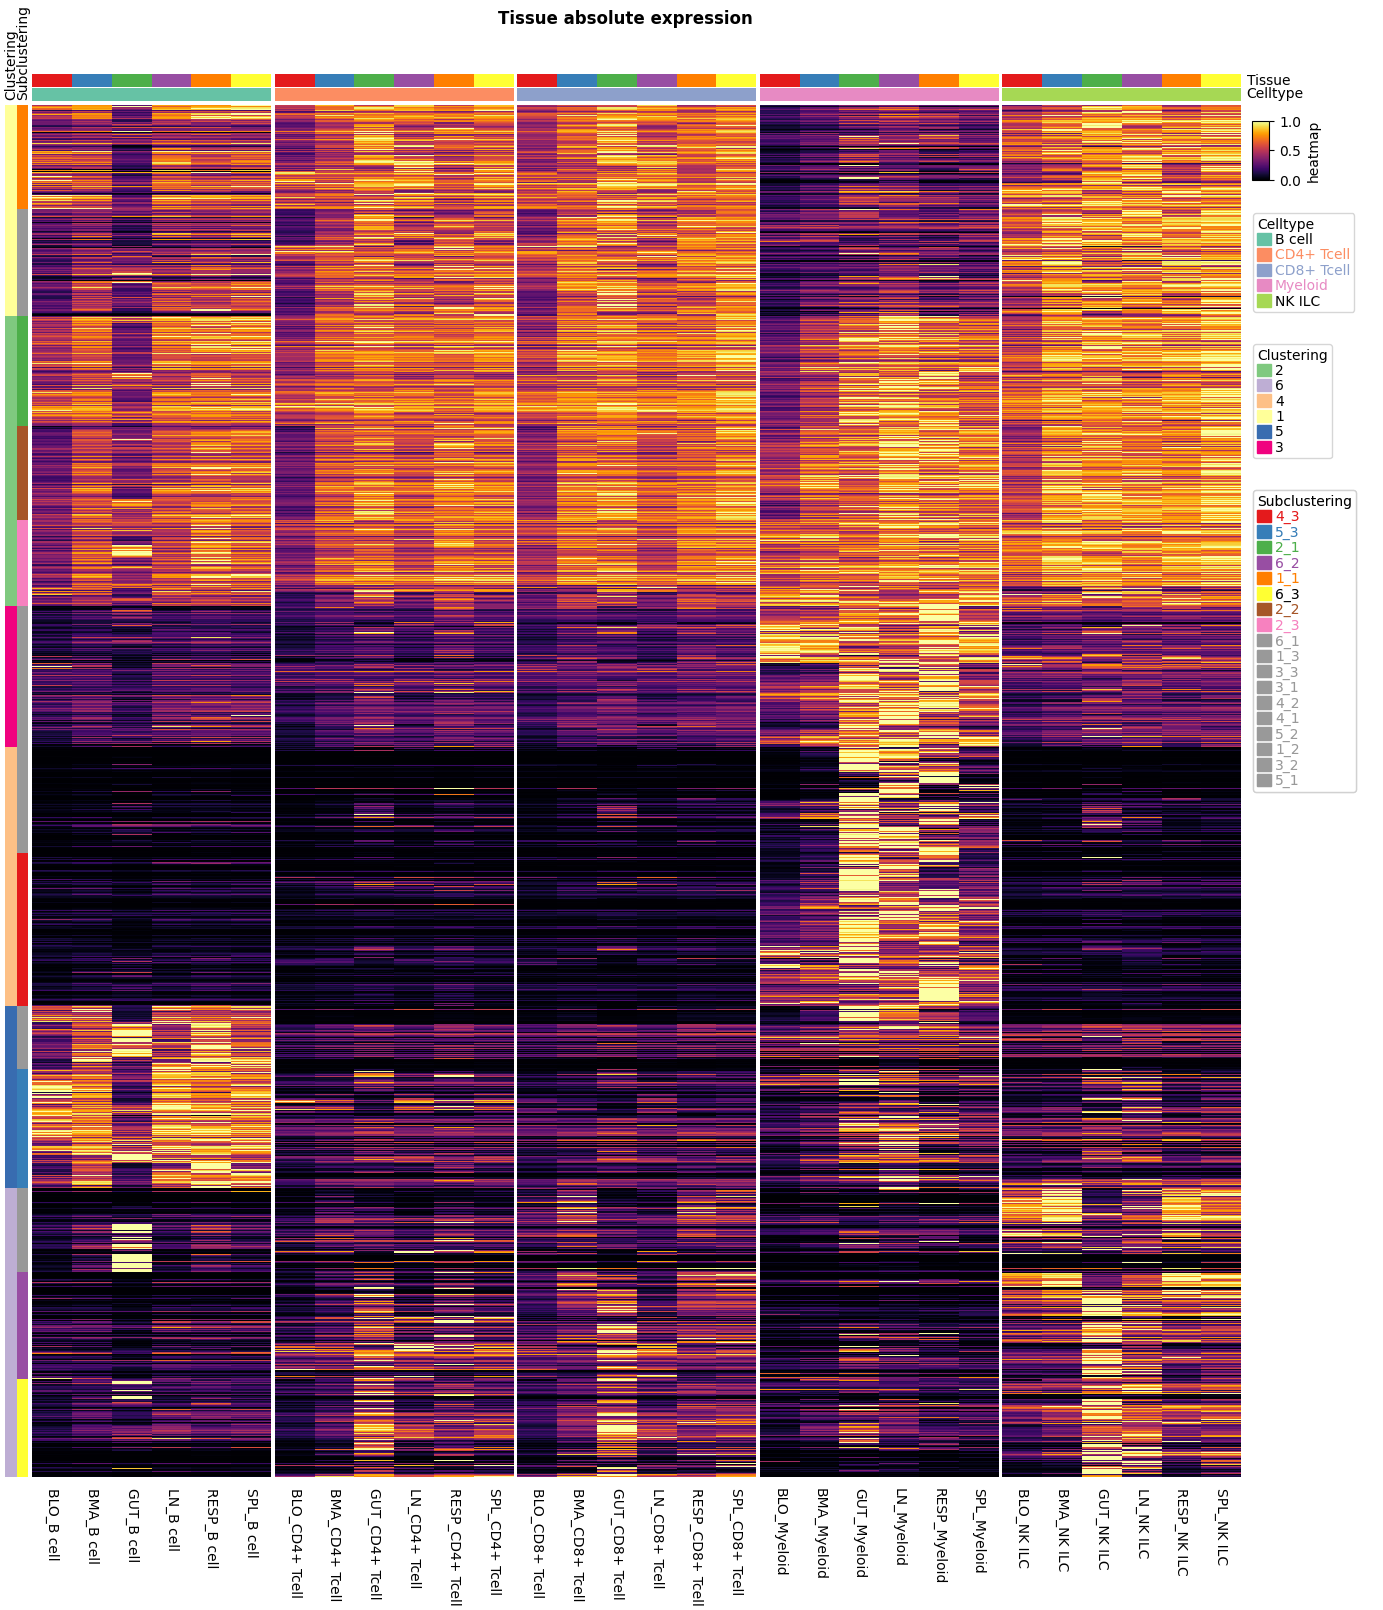

In [836]:
df_plot_norm = df_plot_norm.loc[gene_order]

col_split = [col.split('_') for col in df_plot.columns]
# Sort by STRING2 and then by STRING1
sorted_cols = sorted(col_split, key=lambda x: (x[1], x[0]))
df_plot = df_plot[['_'.join(col) for col in sorted_cols]]

donor_info = pd.DataFrame(columns=['tissue', 'celltype'], index=df_plot_norm.columns)
donor_info['tissue'] = [i.split('_')[0] for i in df_plot_norm.columns]
donor_info['celltype'] = [i.split('_')[1] for i in df_plot_norm.columns]
    
col_ha = complex_heat.HeatmapAnnotation(
    Tissue=complex_heat.anno_simple(donor_info['tissue'],cmap='Set1',rasterized=True, legend=False),
    Celltype=complex_heat.anno_simple(donor_info['celltype'],cmap='Set2',rasterized=True, legend=True),
    axis=1
)

row_ha = complex_heat.HeatmapAnnotation(
    Clustering=complex_heat.anno_simple(clustering['clusters'],cmap='Accent',rasterized=True),
    Subclustering=complex_heat.anno_simple(clustering['subclusters'],cmap='tab20b',rasterized=True),
    axis=0
)
    
plt.figure(figsize=(16, 16))
cm = complex_heat.ClusterMapPlotter(
    data=df_plot_norm, left_annotation=row_ha, top_annotation=col_ha, legend_anchor='ax_heatmap', legend_vpad=5,
    z_score=None,
    row_cluster=False, col_cluster=False,
    col_split=donor_info['celltype'], #row_split=clustering['subclusters'],
    rasterized=False, legend=True,
    cmap='inferno',
    show_rownames=False, show_colnames=True,
    col_split_gap=1,row_split_gap=1,
    vmax=1,
)
cm.ax.set_title('Tissue absolute expression',y=1.03,fontdict={'fontweight':'bold'})
plt.savefig("clustermap_tissue_expression_up.pdf", bbox_inches='tight')
plt.show()

In [838]:
list(clustering.loc[clustering['clusters']==3].index)

['ABCC5',
 'ABCG1',
 'ABHD12',
 'ABHD5',
 'ABL2',
 'ACOT13',
 'ACOT2',
 'ACSF2',
 'ACY1',
 'ADCY3',
 'AKR1A1',
 'ALAS1',
 'ALOX5AP',
 'AMDHD2',
 'APIP',
 'ARHGAP10',
 'ATP6AP1',
 'ATP6V1C1',
 'CALU',
 'CBR1',
 'CD274',
 'CD58',
 'CD81',
 'CD84',
 'CHCHD6',
 'CNDP2',
 'CREBL2',
 'CTNS',
 'CYSTM1',
 'DNASE2',
 'DNPH1',
 'DOCK7',
 'EPSTI1',
 'FUOM',
 'GADD45G',
 'GBA',
 'GBP1',
 'GLA',
 'GLMP',
 'GNPDA1',
 'HEXA',
 'HPGD',
 'HSD17B4',
 'IFIT2',
 'IFT74',
 'ISG15',
 'KIF16B',
 'LAMP2',
 'LRPAP1',
 'MMD',
 'MX1',
 'OASL',
 'OSM',
 'PCBD1',
 'PDE4DIP',
 'PHLDA1',
 'PLOD3',
 'PNPO',
 'POR',
 'PRDX1',
 'PRXL2A',
 'RASGEF1B',
 'REEP3',
 'SLC16A3',
 'SLC25A19',
 'SLC26A11',
 'SLC2A8',
 'SLC43A3',
 'SLFN11',
 'SMIM30',
 'SORBS3',
 'SRD5A3',
 'STMN1',
 'STX6',
 'TANC2',
 'TFPT',
 'TMEM14C',
 'TMEM273',
 'TNFAIP8L2',
 'TUBA1B',
 'TUBA1C',
 'TUBB',
 'YWHAH',
 'ZBED3',
 'ZFYVE21',
 'ZNF331',
 'BCKDK',
 'CASP1',
 'CEBPD',
 'COMT',
 'CTNNA1',
 'CTSA',
 'DCAF12',
 'DSE',
 'E2F3',
 'EVA1B',
 'GALK1',
 'G

In [842]:
df['masked_logFC'] = df['logFC']
df.loc[np.logical_or(df['adj.P.Val']>0.05, df['mean_expression_normalized']<0.05), 'masked_logFC'] = 0

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..


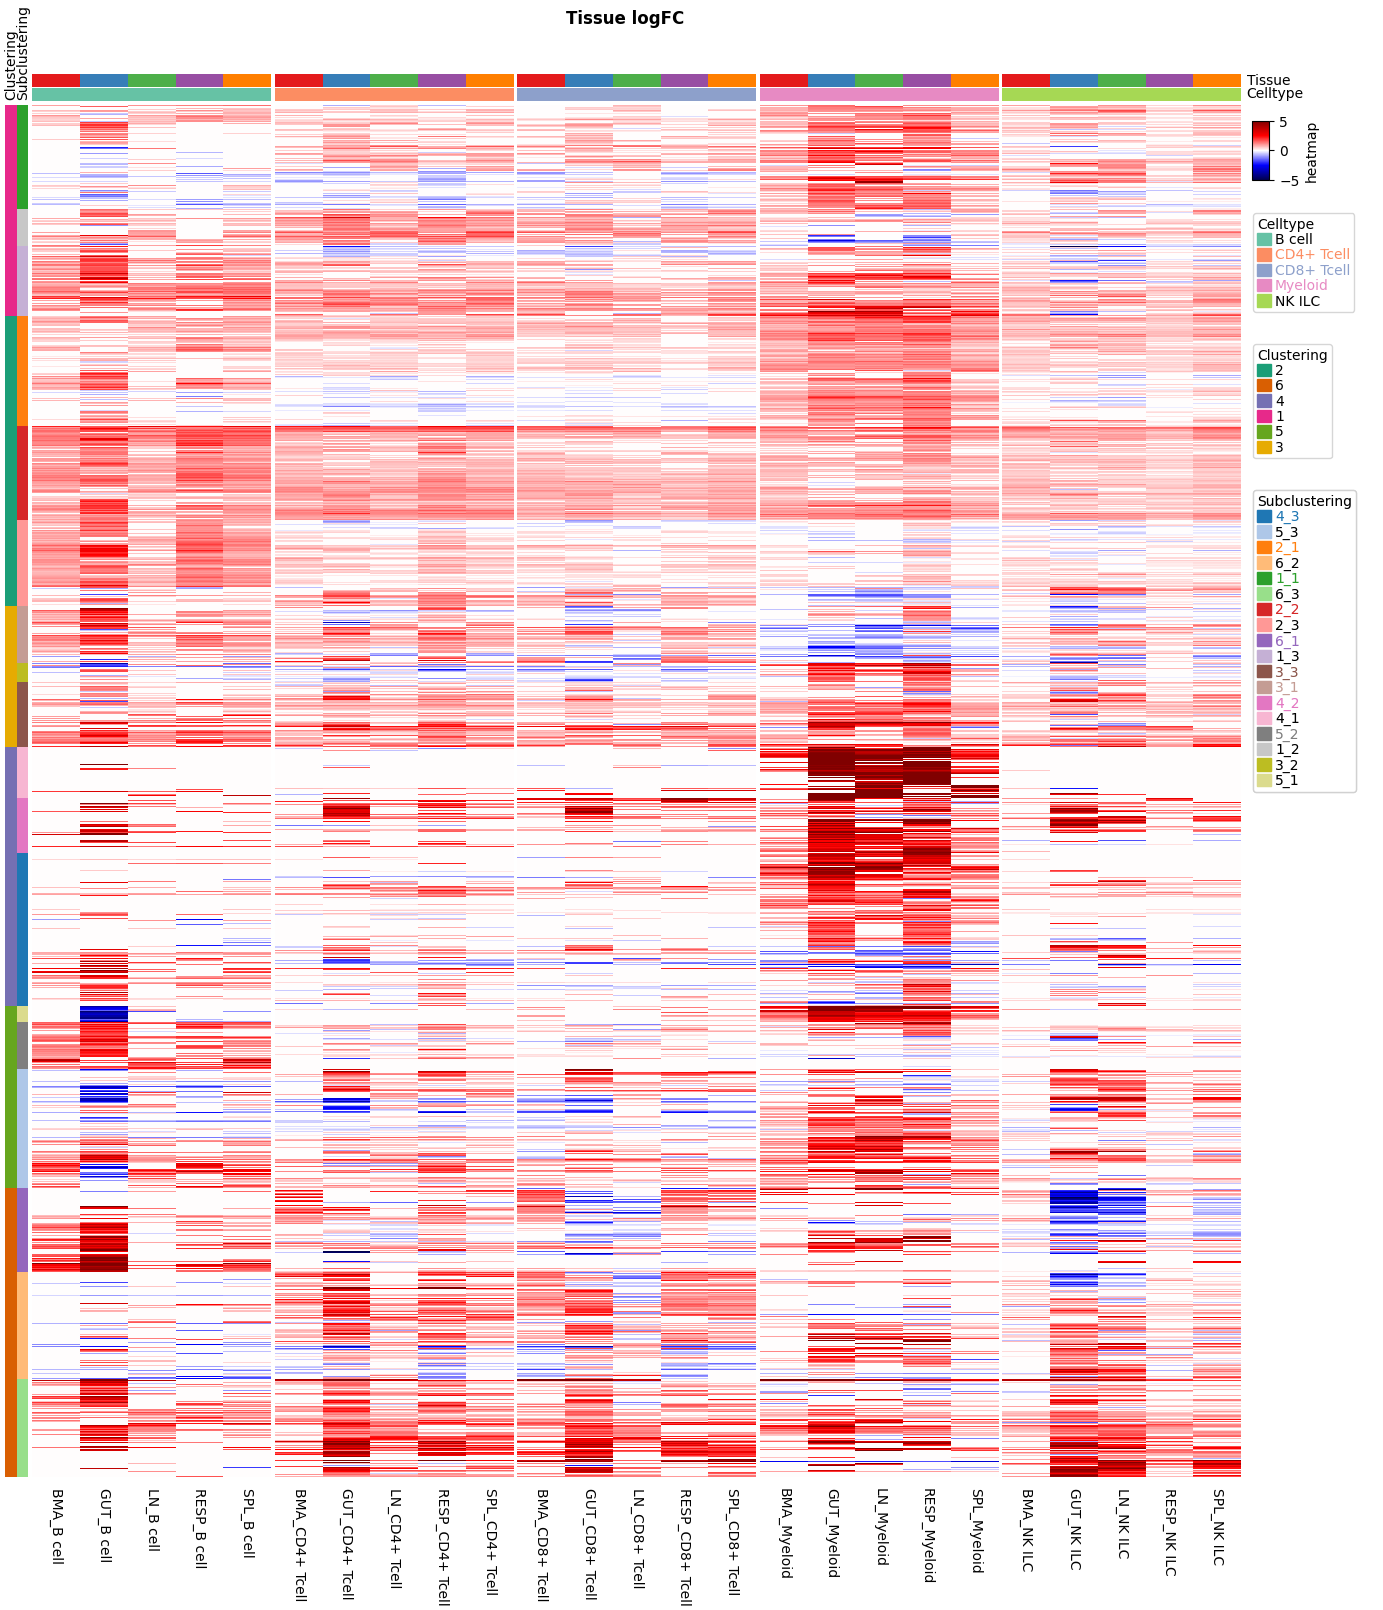

In [843]:
df_plot_lfc = df.pivot(index='assay_group', columns='ID', values='masked_logFC')[list(df_plot_norm.index)].T
df_plot_lfc.fillna(0, inplace=True)
df_plot_lfc = df_plot_lfc.loc[gene_order]

col_split = [col.split('_') for col in df_plot_lfc.columns]
# Sort by STRING2 and then by STRING1
sorted_cols = sorted(col_split, key=lambda x: (x[1], x[0]))
df_plot_lfc = df_plot_lfc[['_'.join(col) for col in sorted_cols]]

donor_info = pd.DataFrame(columns=['tissue', 'celltype'], index=df_plot_lfc.columns)
donor_info['tissue'] = [i.split('_')[0] for i in df_plot_lfc.columns]
donor_info['celltype'] = [i.split('_')[1] for i in df_plot_lfc.columns]
    
col_ha = complex_heat.HeatmapAnnotation(
    Tissue=complex_heat.anno_simple(donor_info['tissue'],cmap='Set1',rasterized=True, legend=False),
    Celltype=complex_heat.anno_simple(donor_info['celltype'],cmap='Set2',rasterized=True, legend=True),
    axis=1
)

row_ha = complex_heat.HeatmapAnnotation(
    Clustering=complex_heat.anno_simple(clustering['clusters'],cmap='Dark2',rasterized=True),
    Subclustering=complex_heat.anno_simple(clustering['subclusters'],cmap='tab20',rasterized=True),
    axis=0
)
    
plt.figure(figsize=(16, 16))
cm = complex_heat.ClusterMapPlotter(
    data=df_plot_lfc, left_annotation=row_ha, top_annotation=col_ha, legend_anchor='ax_heatmap', legend_vpad=5,
    z_score=None,
    row_cluster=False, col_cluster=False,
    col_split=donor_info['celltype'], #row_split=clustering['clusters'],
    rasterized=False, legend=True,
    cmap='seismic',
    show_rownames=False, show_colnames=True,
    col_split_gap=1,row_split_gap=1,
    vmax=5, vmin=-5
)
cm.ax.set_title('Tissue logFC',y=1.03,fontdict={'fontweight':'bold'})
plt.savefig("clustermap_tissue_up.pdf", bbox_inches='tight')
plt.show()

In [844]:
df_plot_lfc['clustering'] = clustering['clusters']
df_plot_lfc['subclustering'] = clustering['subclusters']
df_plot_lfc.to_parquet('de_results_tissue_clustered_up.gzip', compression='gzip') 

In [845]:
df_plot_norm['clustering'] = clustering['clusters']
df_plot_norm['subclustering'] = clustering['subclusters']
df_plot_norm.to_parquet('de_results_tissue_clustered_expression_up.gzip', compression='gzip') 


In [1108]:
df_plot_tissue = pd.read_parquet('de_results_tissue_clustered_expression_up.gzip') 

In [1112]:
df_plot_tissue.loc[df_plot_tissue['subclustering']=='2_2'].sort_index()

,BLO_B cell,BMA_B cell,GUT_B cell,LN_B cell,RESP_B cell,SPL_B cell,BLO_CD4+ Tcell,BMA_CD4+ Tcell,GUT_CD4+ Tcell,LN_CD4+ Tcell,...,RESP_Myeloid,SPL_Myeloid,BLO_NK ILC,BMA_NK ILC,GUT_NK ILC,LN_NK ILC,RESP_NK ILC,SPL_NK ILC,clustering,subclustering
ID,,,,,,,,,,,,,,,,,,,,,
ABRACL,0.153375,0.233175,0.115108,0.209210,0.269268,0.313534,0.362817,0.694151,0.856670,0.763517,...,0.538908,0.963467,0.307847,0.516012,0.641484,0.639844,0.465480,0.556498,2,2_2
ACADM,0.412859,0.810855,0.441967,0.892447,0.901676,1.000000,0.221768,0.527517,0.630806,0.510182,...,0.452207,0.517285,0.361598,0.672758,0.688267,0.686569,0.616261,0.770139,2,2_2
ACSL5,0.395255,0.519708,0.232461,0.598534,0.598772,0.670171,0.257079,0.575563,0.801401,0.528629,...,0.596628,0.611086,0.622943,0.801640,0.870724,0.691998,0.836955,0.784904,2,2_2
AIFM1,0.279914,0.571546,0.386194,0.511025,0.671456,0.614213,0.331645,0.610485,0.618734,0.562289,...,0.860041,0.918865,0.559143,0.817157,0.774292,0.837978,0.754553,0.839180,2,2_2
ALDH3A2,0.181133,0.280927,0.205018,0.299258,0.340648,0.314854,0.225060,0.334945,0.357233,0.443446,...,1.000000,0.758822,0.401314,0.511469,0.660889,0.751387,0.593264,0.730858,2,2_2
AP1S1,0.305934,0.422581,0.220985,0.465706,0.533644,0.502037,0.261963,0.448236,0.524939,0.389357,...,0.989784,0.809709,0.316679,0.310855,0.933467,0.507417,0.345325,0.399904,2,2_2
ARFRP1,0.377922,0.626282,0.308889,0.681135,0.632313,0.642857,0.352163,0.867003,0.789415,0.864196,...,0.510421,0.578110,0.586948,1.000000,0.745136,0.786980,0.937864,0.984937,2,2_2
ARL1,0.484037,0.682082,1.000000,0.629679,0.751057,0.673405,0.372161,0.583687,0.687856,0.575841,...,0.676166,0.495486,0.505370,0.662822,0.693846,0.701185,0.714479,0.713209,2,2_2
ARL6IP6,0.460871,0.583232,0.226979,0.654293,0.615353,0.502036,0.345207,0.691136,1.000000,0.674404,...,0.429495,0.351431,0.374539,0.710828,0.714418,0.732280,0.660593,0.716056,2,2_2


# Age DE

In [1172]:
import upsetplot
from upsetplot import UpSet

In [1173]:
tissue_groups = ['resp', 'ln', 'gut', 'bma', 'spl', 'blo']

In [1174]:
df = pd.DataFrame()
for tissue_group in tissue_groups:
    df_tissue = pd.read_csv(f"results_dreamlet/aging_{tissue_group}_age_vs_blood_random.csv")
    df_tissue["tissue_groups"] = tissue_group
    df = pd.concat([df, df_tissue], axis=0)
df = df.loc[~df['assay'].str.contains('Mast')]

In [ ]:
2

In [ ]:
df[df['ID']=='RASGEF1']

In [1175]:
logfc = 1
pval = 0.05
mask_genes = (df["adj.P.Val"] < 0.05) & (df["logFC"] > logfc)
genes = df[mask_genes].ID.unique()
len(genes)

1567

In [1176]:
immune_aging_sub[:, 'APOE']

View of AnnData object with n_obs × n_vars = 1224601 × 1
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'library', 'donor', 'site', 'age', 'sex', 'sample', 'chemistry', 'n_proteins', '_scvi_batch', '_scvi_labels', 'overclustering_percolate', 'sum_percolation_score', 'tissue', 'batch', 'bcr_library_id', 'tcr_library_id', 'celltypes_steven', 'celltypes_steven_old', 'dan_correction', 'schpf_groups', 'fine_celltypes', 'tissue_groups', 'mrvi_groups', 'donor_tissue', 'donor_tissue_annotation', 'donor_tissue_groups', 'donor_tissue_groups_coarse', 'donor_tissue_groups_fine', 'cmv', 'ebv', 'DCD/DBD', 'height', 'bmi', 'smoking_period', 'age_int', 'age_group'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'hsp', 'is_highly_variable_gene_batch_key_donor_id', 'is_highly_variable_gene_batch_key_donor_id+tissue', 'enrichment_target', 'gene_names', 'n_counts'
    obsm: 'BCR_IR', 'TCR_IR', 'X_pca', 'X_scvi_integrated_batch_key_donor_id', 'X_scvi_integrated_batch_key_donor_id+tissue

In [1177]:
df.loc[mask_genes, 'assay'].value_counts()

CD8+ Tcell    757
CD4+ Tcell    705
B cell        375
NK ILC        320
Myeloid       305
Name: assay, dtype: int64

In [1178]:
#collect genes for each tissue x celltype
genes_comparison = dict()
genes_comparison_group = dict()
genes_all = []
percent_min = 0.01
genes_plot = dict()
subsets_analysis = list(df['assay'].unique())
logFC = 0.5

In [1179]:
subsets_analysis

['Myeloid', 'CD4+ Tcell', 'NK ILC', 'CD8+ Tcell', 'B cell']

In [1180]:
for group in tissue_groups:
    genes_comparison_group = dict()
    group_upper = group.upper()
    for celltype in subsets_analysis:
        mask_group_celltype = (df["adj.P.Val"] < 0.05) & (abs(df["logFC"]) > logfc) & (df['tissue_groups'] == group) & (df["assay"] == celltype)
        print(group_upper, celltype, np.sum(mask_group_celltype))
        genes_group_celltype = df[mask_group_celltype].ID.unique()
        genes_group_celltype = np.intersect1d(genes_group_celltype, immune_aging_sub.var_names)

        ad = immune_aging_sub[(immune_aging_sub.obs['tissue_groups'] == group_upper) & (immune_aging_sub.obs["mrvi_groups"] == celltype), genes_group_celltype]
        
        genes_group_celltype = list(genes_group_celltype[(ad.X.mean(axis=0) > percent_min).tolist()[0]])
        genes_group_celltype = list(genes_group_celltype)
        genes_comparison[f"{group_upper}_{celltype}"] = genes_group_celltype
        genes_comparison_group[f"{celltype}"] = genes_group_celltype
        genes_all = genes_all + genes_group_celltype

    #upsetplot
    plot = upsetplot.from_contents(genes_comparison_group)
    data = upsetplot.query(plot, present=None).data
    data = data.reset_index()
    data = data.set_index("id")
    genes_plot[group_upper] = data[data.T.sum() > 1].index.tolist()

RESP Myeloid 169
RESP CD4+ Tcell 786
RESP NK ILC 193
RESP CD8+ Tcell 46
RESP B cell 0
LN Myeloid 7
LN CD4+ Tcell 155
LN NK ILC 96
LN CD8+ Tcell 488
LN B cell 246
GUT Myeloid 8
GUT CD4+ Tcell 80
GUT NK ILC 70
GUT CD8+ Tcell 259
GUT B cell 107
BMA Myeloid 86
BMA CD4+ Tcell 30
BMA NK ILC 135
BMA CD8+ Tcell 336
BMA B cell 112
SPL Myeloid 52
SPL CD4+ Tcell 58
SPL NK ILC 77
SPL CD8+ Tcell 100
SPL B cell 244
BLO Myeloid 247
BLO CD4+ Tcell 161
BLO NK ILC 55
BLO CD8+ Tcell 131
BLO B cell 89


In [1181]:
plot_all = upsetplot.from_contents(genes_comparison)
data_all = upsetplot.query(plot_all, present=None).data
data_all = data_all.reset_index()
data_all = data_all.set_index("id")
#data_all_grouped = data_all.groupby(by=lambda x: x.split('_')[0], axis=1).sum()
#genes_plot_all = data_all_grouped[(data_all_grouped > 0).sum(axis=1) > 1].index.tolist()
genes_plot_all = data_all[data_all.sum(axis=1) > 1].index.tolist()
genes_plot_all

['AC093512.2',
 'ADAM19',
 'ADGRE1',
 'AL136454.1',
 'AMZ1',
 'APOE',
 'AQP3',
 'BAG3',
 'BEX1',
 'C3orf14',
 'CCDC144A',
 'CCDC173',
 'CCL23',
 'CCL3L1',
 'CCL4',
 'CD3E',
 'CD3G',
 'CDKN2A',
 'CLECL1',
 'CLU',
 'CTSW',
 'DAPL1',
 'DDX43',
 'DNAJB1',
 'DNAJB4',
 'FXYD2',
 'GADD45G',
 'GATD3A',
 'GATD3B',
 'GPR27',
 'GSTM1',
 'HBA1',
 'HBA2',
 'HBB',
 'HES4',
 'HOPX',
 'HOXB7',
 'HSPA1A',
 'HSPA1B',
 'HSPA6',
 'ID1',
 'IFI27',
 'IFI44L',
 'IFITM1',
 'IGLC3',
 'LGALS2',
 'LIMS2',
 'MARCKSL1',
 'MLF1',
 'MMP9',
 'MTRNR2L8',
 'NFE2L3',
 'NRIP3',
 'PCBP3',
 'PCLAF',
 'PHLDA2',
 'PRUNE2',
 'RPS10-NUDT3',
 'RRAD',
 'SIT1',
 'SLC40A1',
 'SLC9A7',
 'SMOX',
 'SPAG5',
 'SULT1A2',
 'TBC1D10C',
 'TNF',
 'TOGARAM2',
 'U2AF1L5',
 'ULBP2',
 'YPEL4',
 'ZFP57',
 'ABHD8',
 'ABI3',
 'ADARB2',
 'ADRB2',
 'AGMAT',
 'AK5',
 'AKAP5',
 'ANKRD37',
 'ANXA1',
 'APOL1',
 'ARG2',
 'ARID3A',
 'ARL4D',
 'ASB2',
 'ATP10D',
 'AVPI1',
 'AXIN2',
 'BAIAP2',
 'BEX5',
 'BIRC3',
 'C3orf62',
 'CAMK1',
 'CCDC184',
 'CCNA2',
 

In [1182]:
len(genes_plot_all)

604

In [1183]:
g = set([item for group in genes_plot for item in genes_plot[group]])

In [1184]:
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = list(gene_symbols)
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((len(new_idx), len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=new_idx
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx, new_idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [1185]:
immune_aging_sub = immune_aging_sub[immune_aging_sub.obs['mrvi_groups']!='Mast Cell']
immune_aging_sub.obs['mrvi_groups'].value_counts()

CD4+ Tcell    357126
B cell        271686
CD8+ Tcell    247158
Myeloid       223513
NK ILC        125118
Name: mrvi_groups, dtype: int64

In [1186]:
df_plot = grouped_obs_mean(immune_aging_sub, 'donor_tissue_groups_coarse', layer='normalized_counts')
df_plot_normalized = df_plot.apply(lambda x: x/x.max(), axis=1)

In [1187]:
df_plot_normalized = df_plot_normalized.reset_index().rename(columns={'index': 'gene_id'})
df_plot_export = df_plot.reset_index().rename(columns={'index': 'gene_id'})
df_plot_normalized

,gene_id,BLO_B cell,BLO_CD4+ Tcell,BLO_CD8+ Tcell,BLO_Myeloid,BLO_NK ILC,BMA_B cell,BMA_CD4+ Tcell,BMA_CD8+ Tcell,BMA_Myeloid,...,RESP_B cell,RESP_CD4+ Tcell,RESP_CD8+ Tcell,RESP_Myeloid,RESP_NK ILC,SPL_B cell,SPL_CD4+ Tcell,SPL_CD8+ Tcell,SPL_Myeloid,SPL_NK ILC
0,A1BG,0.492969,0.442801,0.742305,0.785514,0.179838,0.505680,0.357210,0.436761,0.568025,...,0.521240,0.558777,0.550949,0.516696,0.202001,0.459269,0.544203,0.657874,0.603689,0.331747
1,A3GALT2,0.000000,0.069737,0.054243,0.221221,0.085872,0.057523,0.068865,0.049931,0.357113,...,0.000000,0.078725,0.097907,0.287411,0.080202,0.007608,0.118091,0.030384,0.262166,0.060919
2,A4GNT,0.000000,0.000000,0.000000,0.012015,0.000000,0.000000,0.000000,0.021356,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.022446,0.000000,0.034771,0.059548,0.000000
3,AAAS,0.637317,0.420111,0.577521,0.375400,0.735852,0.855097,0.720268,0.803345,0.493704,...,0.800337,0.680386,0.827497,0.576183,0.820261,0.867195,0.787240,0.819025,0.557758,0.992881
4,AACS,0.260739,0.221456,0.299559,0.247789,0.490343,0.358765,0.290951,0.387908,0.228329,...,0.358005,0.306019,0.396801,0.288813,0.599814,0.376246,0.388835,0.483454,0.265497,0.737147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14793,ZXDC,1.000000,0.632082,0.748259,0.461909,0.765414,0.714769,0.565403,0.643110,0.365304,...,0.699454,0.553279,0.722655,0.350983,0.722787,0.623980,0.634623,0.712651,0.426097,0.798987
14794,ZYG11A,0.414467,0.088714,0.027163,0.012382,0.109301,0.455923,0.059894,0.075457,0.005987,...,1.000000,0.066585,0.085765,0.005661,0.082104,0.313229,0.048852,0.056214,0.015722,0.041508
14795,ZYG11B,0.430351,0.506879,0.413471,0.792617,0.315659,0.427572,0.458704,0.376458,0.741332,...,0.445397,0.462454,0.328521,0.804895,0.358374,0.412079,0.536720,0.365656,1.000000,0.269499
14796,ZYX,0.039867,0.201616,0.261184,1.000000,0.259740,0.039348,0.205138,0.234531,0.829210,...,0.069536,0.378533,0.324417,0.590720,0.204386,0.048304,0.203656,0.188187,0.662221,0.157584


In [1188]:
df_plot_normalized = pd.melt(df_plot_normalized, id_vars=['gene_id'], value_vars=df_plot_normalized.columns[1:])
df_plot_export = pd.melt(df_plot_export, id_vars=['gene_id'], value_vars=df_plot.columns[1:])

In [1189]:
from scipy import stats
import scipy

In [1190]:
from scipy.cluster.hierarchy import linkage, to_tree, leaves_list
from scipy.cluster.hierarchy import fcluster
import PyComplexHeatmap as complex_heat

In [1191]:
df['assay_group'] = df['tissue_groups'].astype(str).str.upper()  + '_' + df['assay'].astype(str)
df.index = df['assay_group']  + '_' + df['ID'].astype(str)

In [1192]:
df_plot_export.index = df_plot_export['variable']  + '_' + df_plot_export['gene_id'].astype(str)
df_plot_normalized.index = df_plot_normalized['variable']  + '_' + df_plot_normalized['gene_id'].astype(str)
df_plot_export.head()

,gene_id,variable,value
BLO_CD4+ Tcell_A1BG,A1BG,BLO_CD4+ Tcell,0.419192
BLO_CD4+ Tcell_A3GALT2,A3GALT2,BLO_CD4+ Tcell,0.000165
BLO_CD4+ Tcell_A4GNT,A4GNT,BLO_CD4+ Tcell,0.000000
BLO_CD4+ Tcell_AAAS,AAAS,BLO_CD4+ Tcell,0.104032
BLO_CD4+ Tcell_AACS,AACS,BLO_CD4+ Tcell,0.036606


In [1193]:
df['mean_expression'] = df_plot_export['value']
df['mean_expression_normalized'] = df_plot_normalized['value']

In [1194]:
#df.to_parquet('de_results_aging.gzip', compression='gzip') 

In [1195]:
df_plot_lfc = df.pivot(index='assay_group', columns='ID', values='mean_expression')[list(genes_plot_all)].T
df_plot_lfc.fillna(0, inplace=True)

In [1196]:
genes = df_plot_lfc.index[df_plot_lfc.max(axis=1) > 0.1]

In [1197]:
df['masked_logFC'] = df['logFC']
df.loc[np.logical_or(df['P.Value']>0.05, df['mean_expression_normalized']<0.01), 'masked_logFC'] = None

In [1198]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [1293]:
df_plot_norm = df_plot.apply(lambda x: x/x.max(), axis=1).loc[genes_plot_all].loc[genes]

df_plot_lfc = df.pivot(index='assay_group', columns='ID', values='masked_logFC')[list(df_plot_norm.index)].T
df_plot_lfc.fillna(0, inplace=True)
df_plot_lfc = df_plot_lfc.loc[genes]
df_plot_lfc_clustering = np.sign(df_plot_lfc)

Z = linkage(df_plot_norm, method="ward", metric="euclidean")
clusters = fcluster(Z, t=6, criterion='maxclust')
clustering = pd.DataFrame(clusters, index=df_plot_norm.index, columns=['clusters'])

leaves_order = []

for cluster_id in set(clusters):
    cluster_indices = [index for index, label in enumerate(clusters) if label == cluster_id]
    cluster_data = df_plot_lfc_clustering.iloc[cluster_indices, :]
    
    # Compute linkage for this cluster and get the leaves ordering
    Z_cluster = linkage(cluster_data, method="complete", metric="euclidean")
    leaf_order_cluster = leaves_list(Z_cluster)
    clustering.loc[clustering['clusters']==cluster_id, 'subclusters'] = [str(cluster_id) + '_' + str(i) for i in fcluster(Z_cluster, t=3, criterion='maxclust')]
    
    # Adjust indices based on the original dataframe
    ordered_indices = [cluster_indices[i] for i in leaf_order_cluster]
    
    leaves_order.extend(ordered_indices)
    
gene_order = df_plot_lfc.index[leaves_order]

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..


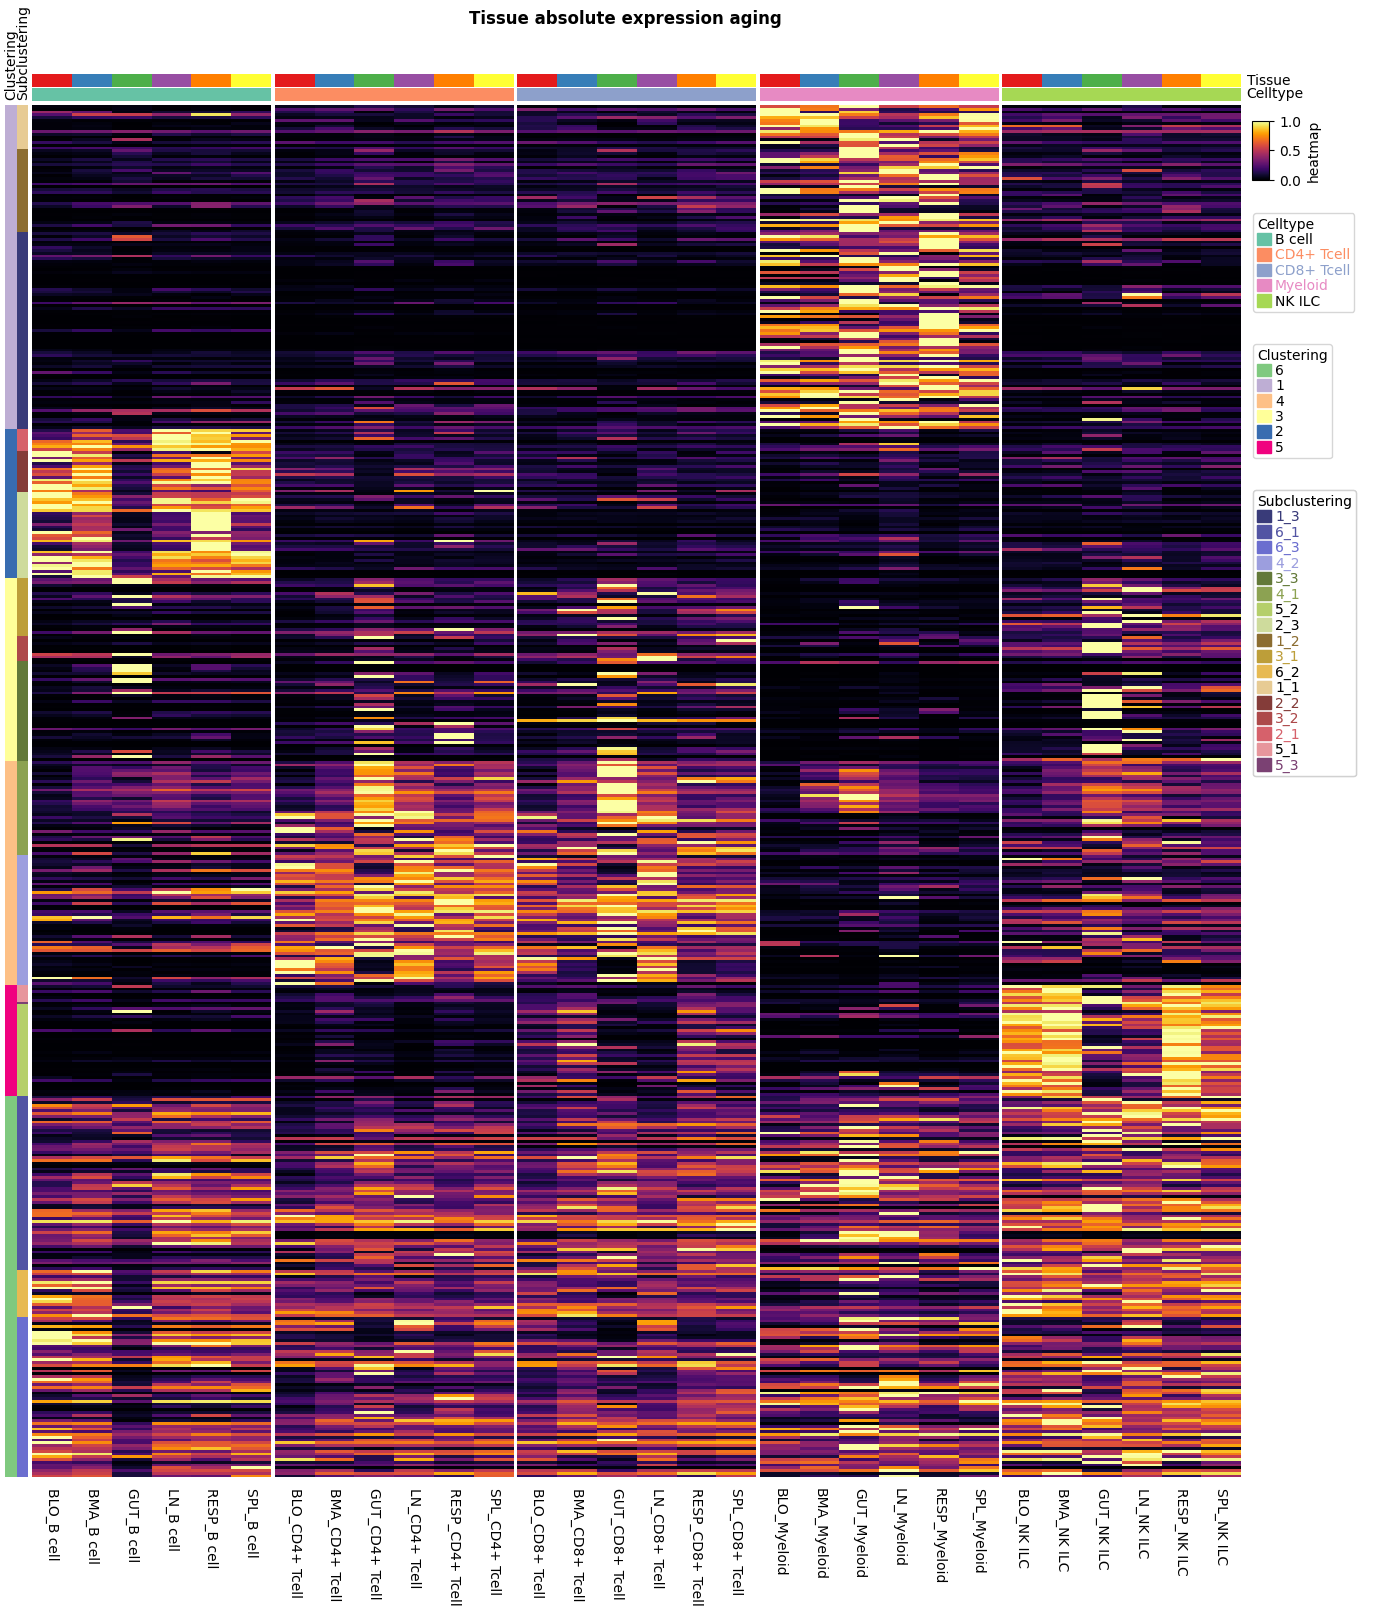

In [1294]:
df_plot_norm = df_plot_norm.loc[gene_order]

col_split = [col.split('_') for col in df_plot.columns]
# Sort by STRING2 and then by STRING1
sorted_cols = sorted(col_split, key=lambda x: (x[1], x[0]))
df_plot = df_plot[['_'.join(col) for col in sorted_cols]]

donor_info = pd.DataFrame(columns=['tissue', 'celltype'], index=df_plot_norm.columns)
donor_info['tissue'] = [i.split('_')[0] for i in df_plot_norm.columns]
donor_info['celltype'] = [i.split('_')[1] for i in df_plot_norm.columns]
    
col_ha = complex_heat.HeatmapAnnotation(
    Tissue=complex_heat.anno_simple(donor_info['tissue'],cmap='Set1',rasterized=True, legend=False),
    Celltype=complex_heat.anno_simple(donor_info['celltype'],cmap='Set2',rasterized=True, legend=True),
    axis=1
)

row_ha = complex_heat.HeatmapAnnotation(
    Clustering=complex_heat.anno_simple(clustering['clusters'],cmap='Accent',rasterized=True),
    Subclustering=complex_heat.anno_simple(clustering['subclusters'],cmap='tab20b',rasterized=True),
    axis=0
)
    
plt.figure(figsize=(16, 16))
cm = complex_heat.ClusterMapPlotter(
    data=df_plot_norm, left_annotation=row_ha, top_annotation=col_ha, legend_anchor='ax_heatmap', legend_vpad=5,
    z_score=None,
    row_cluster=False, col_cluster=False,
    col_split=donor_info['celltype'], #row_split=clustering['subclusters'],
    rasterized=False, legend=True,
    cmap='inferno',
    show_rownames=False, show_colnames=True,
    col_split_gap=1,row_split_gap=1,
    vmax=1,
)
cm.ax.set_title('Tissue absolute expression aging',y=1.03,fontdict={'fontweight':'bold'})
plt.savefig("clustermap_aging_expression.pdf", bbox_inches='tight')
plt.show()

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Starting plotting..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations


<Figure size 1600x1600 with 0 Axes>

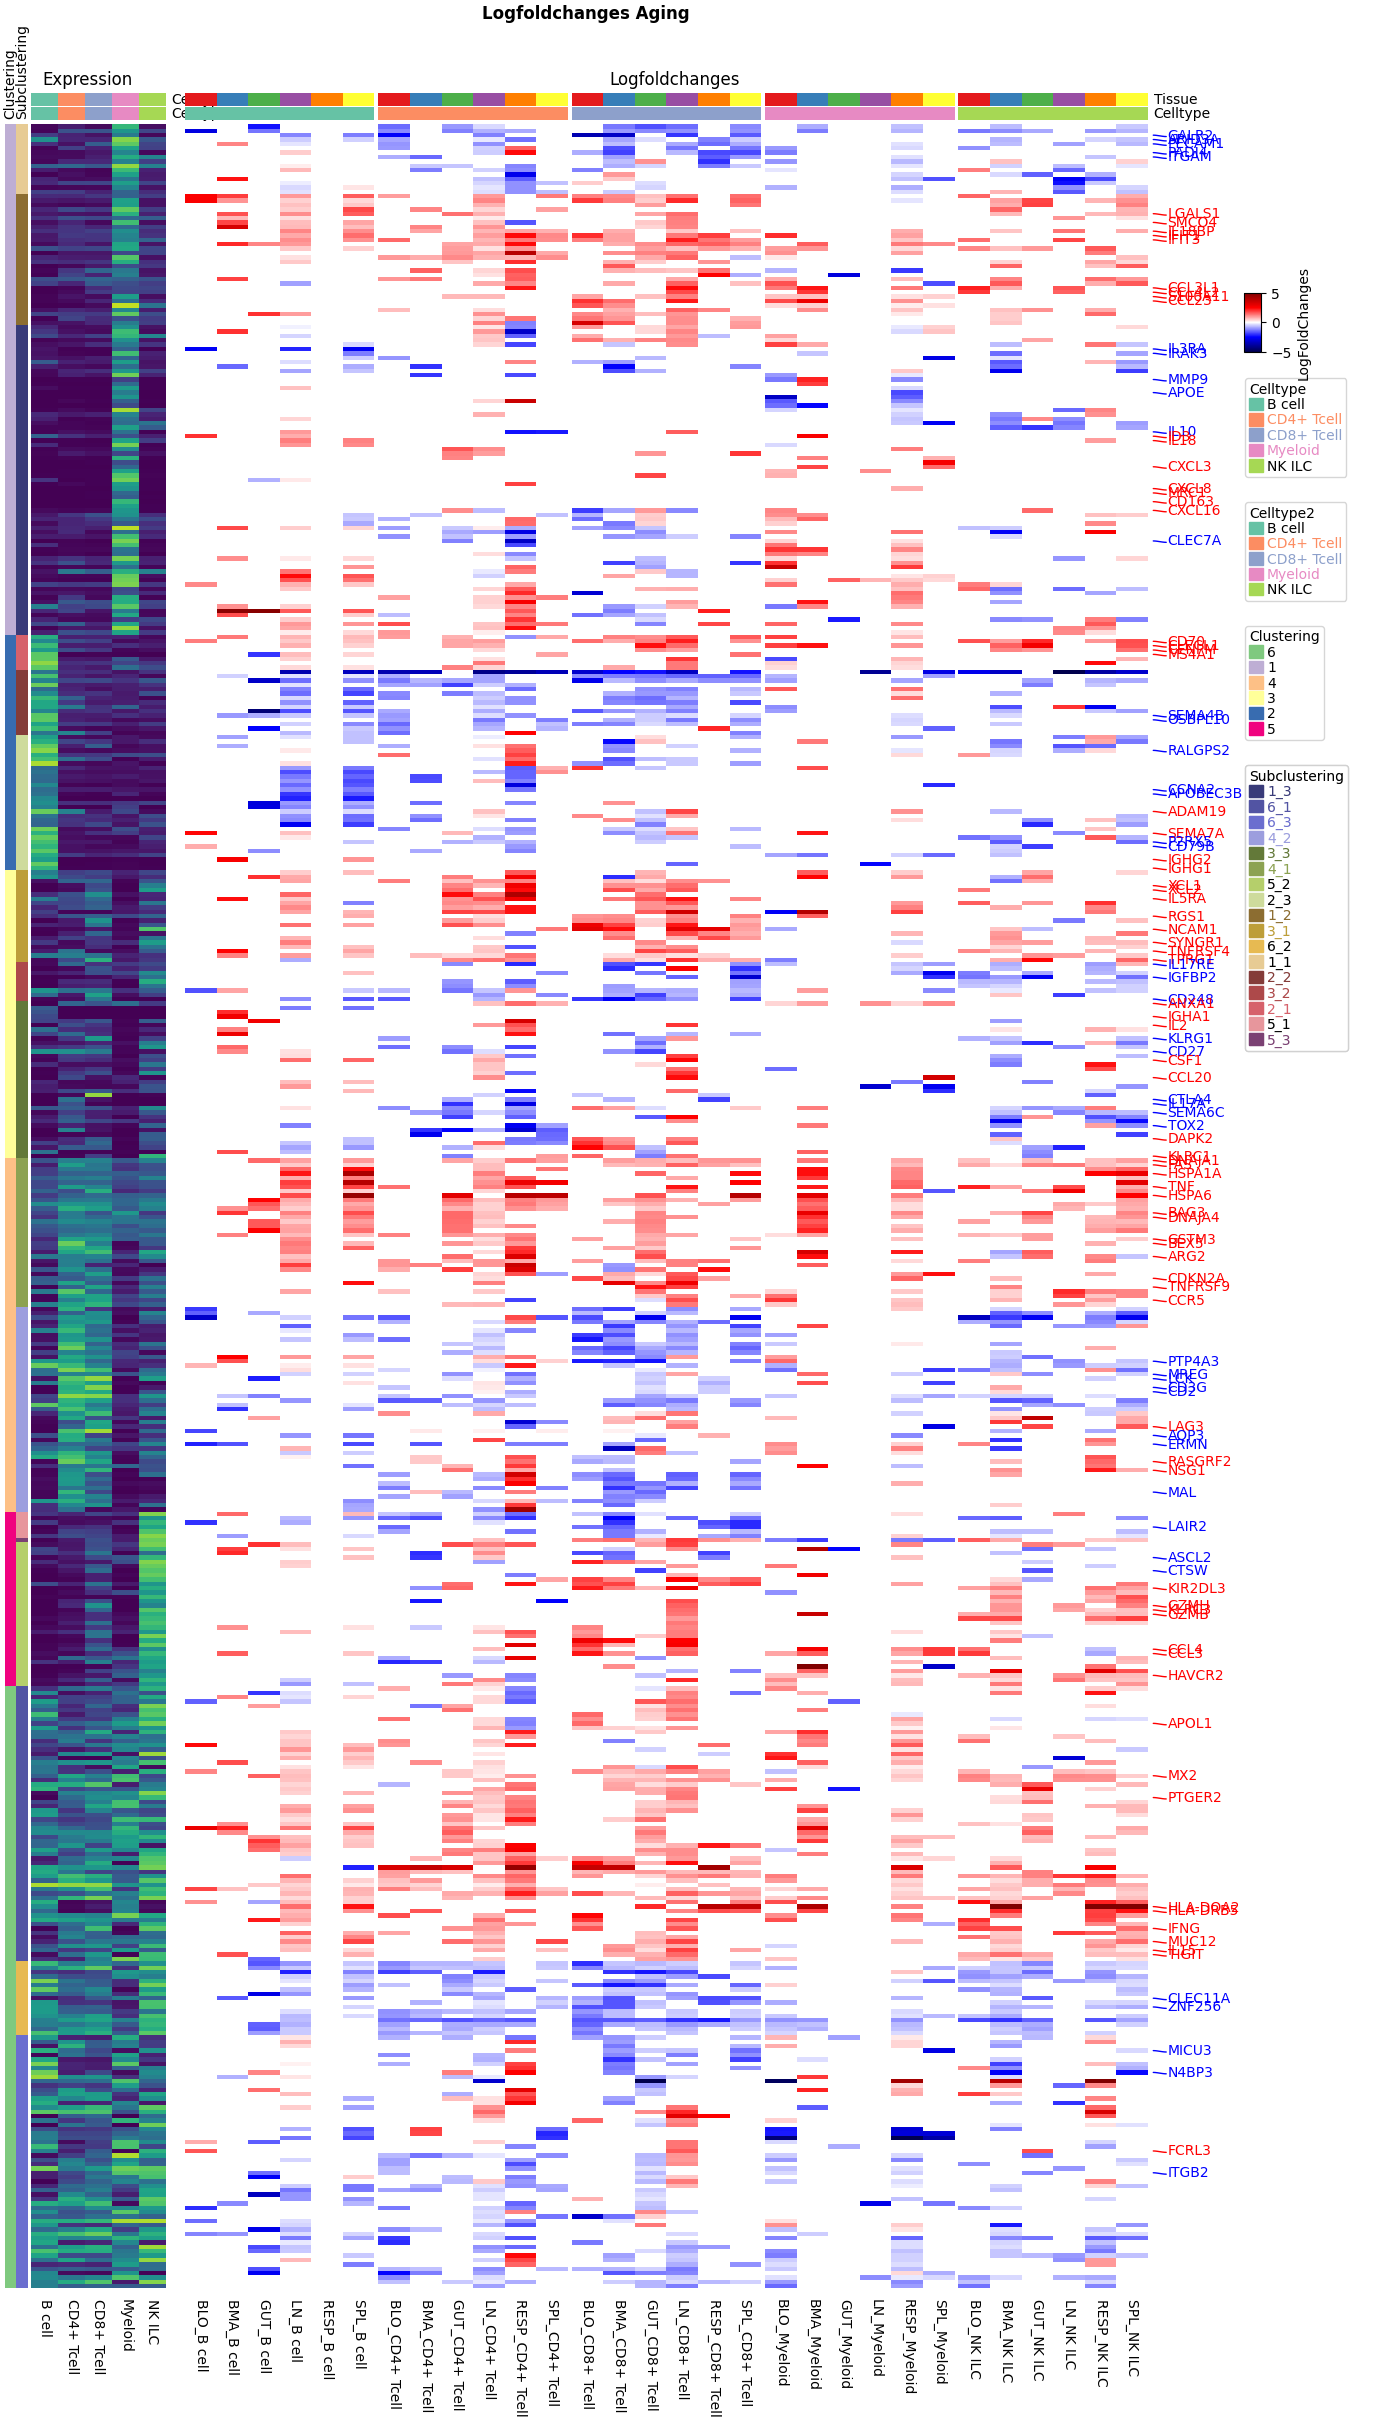

In [1313]:
colors_dict={}
for g in highlight_genes:
    df_plot_lfc.fillna(0, inplace=True)
    if df_plot_lfc.loc[g].mean()<0:
        colors_dict[g]='blue'
    else:
        colors_dict[g]='red'

label_rows = df_plot.apply(lambda x:x.name if x.name in highlight_genes else None, axis=1)

df_plot_norm = df_plot_norm.loc[gene_order]

# Split column names
columns_split = df_plot_norm.columns.str.split('_', expand=True)
str2_values = [i[1] for i in columns_split]

# Group by STR2 and compute the mean
ct_mean_expression = df_plot_norm.groupby(str2_values, axis=1).mean()

sorted_cols = sorted(df_plot.columns, key=lambda x: (x[0]))
df_plot = df_plot[sorted_cols]

donor_info = pd.DataFrame(columns=['celltype'], index=ct_mean_expression.columns)
donor_info['celltype'] = ct_mean_expression.columns
    
col_ha = complex_heat.HeatmapAnnotation(
    Celltype=complex_heat.anno_simple(donor_info['celltype'],cmap='Set2',rasterized=True, legend=True),
    Celltype2=complex_heat.anno_simple(donor_info['celltype'],cmap='Set2',rasterized=True, legend=True),
    axis=1
)

row_ha = complex_heat.HeatmapAnnotation(
    Clustering=complex_heat.anno_simple(clustering['clusters'],cmap='Accent',rasterized=True),
    Subclustering=complex_heat.anno_simple(clustering['subclusters'],cmap='tab20b',rasterized=True),
    axis=0
)

mean_expression = complex_heat.ClusterMapPlotter(
    data=ct_mean_expression, left_annotation=row_ha, top_annotation=col_ha, legend_anchor='ax_heatmap', legend_vpad=5,
    z_score=None,
    row_cluster=False, col_cluster=False,
    rasterized=False, legend=False,
    cmap='viridis',
    show_rownames=False, show_colnames=True,
    col_split_gap=1,row_split_gap=1,
    vmax=1, plot=False, label='Mean Expression'
)

df_plot_lfc = df.pivot(index='assay_group', columns='ID', values='masked_logFC')[list(df_plot_norm.index)].T
df_plot_lfc = df_plot_lfc.loc[gene_order]

col_split = [col.split('_') for col in df_plot_lfc.columns]
# Sort by STRING2 and then by STRING1
sorted_cols = sorted(col_split, key=lambda x: (x[1], x[0]))
df_plot_lfc = df_plot_lfc[['_'.join(col) for col in sorted_cols]]

donor_info = pd.DataFrame(columns=['tissue', 'celltype'], index=df_plot_lfc.columns)
donor_info['tissue'] = [i.split('_')[0] for i in df_plot_lfc.columns]
donor_info['celltype'] = [i.split('_')[1] for i in df_plot_lfc.columns]
    
col_ha = complex_heat.HeatmapAnnotation(
    Tissue=complex_heat.anno_simple(donor_info['tissue'],cmap='Set1',rasterized=True, legend=False),
    Celltype=complex_heat.anno_simple(donor_info['celltype'],cmap='Set2',rasterized=True, legend=True),
    axis=1
)

row_ha_right = complex_heat.HeatmapAnnotation(
    selected=complex_heat.anno_label(label_rows, colors=colors_dict,
                       relpos=(0,0.4)),
    axis=0,verbose=0,
    #label_kws={'rotation':0,'horizontalalignment':'right','verticalalignment':'top', },
    orientation='right'
    )
    
plt.figure(figsize=(16, 16))

cm = complex_heat.ClusterMapPlotter(
    data=df_plot_lfc, left_annotation=None, top_annotation=col_ha, legend_anchor='ax_heatmap', legend_vpad=5,
    z_score=None, right_annotation=row_ha_right,
    row_cluster=False, col_cluster=False,
    col_split=donor_info['celltype'], #row_split=clustering['clusters'],
    rasterized=False, legend=True,
    cmap='seismic',
    show_rownames=False, show_colnames=True,
    col_split_gap=1,row_split_gap=1,
    vmax=5, vmin=-5, plot=False, label='LogFoldChanges'
)

cmlist=[mean_expression, cm]

plt.figure(figsize=(15,25))
ax,legend_axes=complex_heat.composite(cmlist=cmlist, main=0,legend_hpad=50,col_gap=3)
mean_expression.ax.set_title("Expression")
cm.ax.set_title("Logfoldchanges")
ax.set_title("Logfoldchanges Aging",y=1.03,fontdict={'fontweight':'bold','color':'black'})
plt.savefig("logfoldchanges_aging.pdf", bbox_inches='tight')
plt.show()

In [ ]:
pd.set_option('display.max_rows', 500)

In [1305]:
highlight_genes = """,
IFIT3, IFIT1, CCL23, CCL3L1, CCL4L2, IL3RA, IRAK3, CXCL16, MMP9, ID3, CXCL3, APOE, CXCL8, MRC1, IL18, IL18BP, LGALS1, S100A11, CD163,
IL10, CLEC7A, PADI4, SMCO4,
GALR2, PADI4, ITGAM, ARID3A, PECAM1,
CLECL1, CD70, CENPM, ADAM19,
MS4A1, APOBEC3B, CCNA2, RALGPS2, OSBPL10, SEMA7A, CD79B, P2RX5, IGHG1, IGHG2, SEMA4B, IGHG2,
IL17RE, CTLA4, SEMA6C, CD27, IL17A, TOX2, IGFBP2, KLRG1, CD248,
KLRC1, NCAM1, DAPK2, RGS1, TPRG1,
ANXA1, SYNGR1, TNFRSF4, IGHA1, CCL20, CSF1, IL2, IL5RA, XCL1, XCL2,
PTP4A3, NSG1, RASGRF2, MAL, AQP3, CD2, CD3G, LCK, MREG,
HSPA1A, HSPA6,
CDKN2A, BEX5, GSTM3, TNFRSF9, ERMN, LAG3, ARG2, CCR5, FAS,
TNF, BAG3, DNAJA4, DNAJA1,
ASCL2, LAIR2, CTSW,
CCL4, CCL3, GZMB, HAVCR2, GZMH, KLRC3, KIR2DL3, KLRG1,
ITGB2, CLEC11A, MICU3, ZNF256,
IFNG, MX2, TIGIT, APOL1, IL15, FCRL3, N4BP3, PTGER2, MUC12, HLA-DQA2, HLA-DRB5"""

In [1314]:
df_plot

,BLO_B cell,BMA_B cell,BLO_CD4+ Tcell,BMA_CD4+ Tcell,BLO_CD8+ Tcell,BMA_CD8+ Tcell,BLO_Myeloid,BMA_Myeloid,BLO_NK ILC,BMA_NK ILC,...,RESP_B cell,RESP_CD4+ Tcell,RESP_CD8+ Tcell,RESP_Myeloid,RESP_NK ILC,SPL_B cell,SPL_CD4+ Tcell,SPL_CD8+ Tcell,SPL_Myeloid,SPL_NK ILC
A1BG,0.466685,0.478718,0.419192,0.338164,0.702727,0.413474,0.743632,0.537739,0.170249,0.153883,...,0.493449,0.528985,0.521574,0.489147,0.191230,0.434782,0.515188,0.622798,0.571502,0.314059
A3GALT2,0.000000,0.000136,0.000165,0.000163,0.000128,0.000118,0.000522,0.000843,0.000203,0.000082,...,0.000000,0.000186,0.000231,0.000679,0.000189,0.000018,0.000279,0.000072,0.000619,0.000144
A4GNT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000073,0.000041,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.003431,0.000000,0.000077,0.000000,0.000119,0.000204,0.000000
AAAS,0.157818,0.211747,0.104032,0.178359,0.143011,0.198932,0.092960,0.122256,0.182218,0.247629,...,0.198187,0.168483,0.204913,0.142680,0.203121,0.214743,0.194944,0.202814,0.138117,0.245866
AACS,0.043099,0.059302,0.036606,0.048093,0.049516,0.064119,0.040958,0.037742,0.081052,0.073800,...,0.059177,0.050584,0.065590,0.047740,0.099147,0.062192,0.064273,0.079913,0.043886,0.121847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,0.490868,0.350857,0.310269,0.277538,0.367296,0.315682,0.226737,0.179316,0.375717,0.382721,...,0.343340,0.271587,0.354728,0.172286,0.354793,0.306292,0.311516,0.349818,0.209157,0.392197
ZYG11A,0.006955,0.007651,0.001489,0.001005,0.000456,0.001266,0.000208,0.000100,0.001834,0.000651,...,0.016781,0.001117,0.001439,0.000095,0.001378,0.005256,0.000820,0.000943,0.000264,0.000697
ZYG11B,0.139879,0.138976,0.164754,0.149095,0.134393,0.122362,0.257628,0.240959,0.102600,0.096335,...,0.144770,0.150314,0.106781,0.261619,0.116484,0.133940,0.174453,0.118851,0.325035,0.087597
ZYX,0.249183,0.245939,1.260185,1.282201,1.632511,1.465917,6.250429,5.182919,1.623488,1.489733,...,0.434631,2.365996,2.027744,3.692257,1.277498,0.301923,1.272936,1.176248,4.139169,0.984965


In [1306]:
highlight_genes = [item for sublist in highlight_genes.split(",\n") for item in sublist.split(", ")  if item]

In [1307]:
highlight_genes

['IFIT3',
 'IFIT1',
 'CCL23',
 'CCL3L1',
 'CCL4L2',
 'IL3RA',
 'IRAK3',
 'CXCL16',
 'MMP9',
 'ID3',
 'CXCL3',
 'APOE',
 'CXCL8',
 'MRC1',
 'IL18',
 'IL18BP',
 'LGALS1',
 'S100A11',
 'CD163',
 'IL10',
 'CLEC7A',
 'PADI4',
 'SMCO4',
 'GALR2',
 'PADI4',
 'ITGAM',
 'ARID3A',
 'PECAM1',
 'CLECL1',
 'CD70',
 'CENPM',
 'ADAM19',
 'MS4A1',
 'APOBEC3B',
 'CCNA2',
 'RALGPS2',
 'OSBPL10',
 'SEMA7A',
 'CD79B',
 'P2RX5',
 'IGHG1',
 'IGHG2',
 'SEMA4B',
 'IGHG2',
 'IL17RE',
 'CTLA4',
 'SEMA6C',
 'CD27',
 'IL17A',
 'TOX2',
 'IGFBP2',
 'KLRG1',
 'CD248',
 'KLRC1',
 'NCAM1',
 'DAPK2',
 'RGS1',
 'TPRG1',
 'ANXA1',
 'SYNGR1',
 'TNFRSF4',
 'IGHA1',
 'CCL20',
 'CSF1',
 'IL2',
 'IL5RA',
 'XCL1',
 'XCL2',
 'PTP4A3',
 'NSG1',
 'RASGRF2',
 'MAL',
 'AQP3',
 'CD2',
 'CD3G',
 'LCK',
 'MREG',
 'HSPA1A',
 'HSPA6',
 'CDKN2A',
 'BEX5',
 'GSTM3',
 'TNFRSF9',
 'ERMN',
 'LAG3',
 'ARG2',
 'CCR5',
 'FAS',
 'TNF',
 'BAG3',
 'DNAJA4',
 'DNAJA1',
 'ASCL2',
 'LAIR2',
 'CTSW',
 'CCL4',
 'CCL3',
 'GZMB',
 'HAVCR2',
 'GZMH',
 'KL

In [1251]:
gene_order_sub = [i for i in gene_order if i in highlight_genes]

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Starting plotting..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations


<Figure size 1600x1600 with 0 Axes>

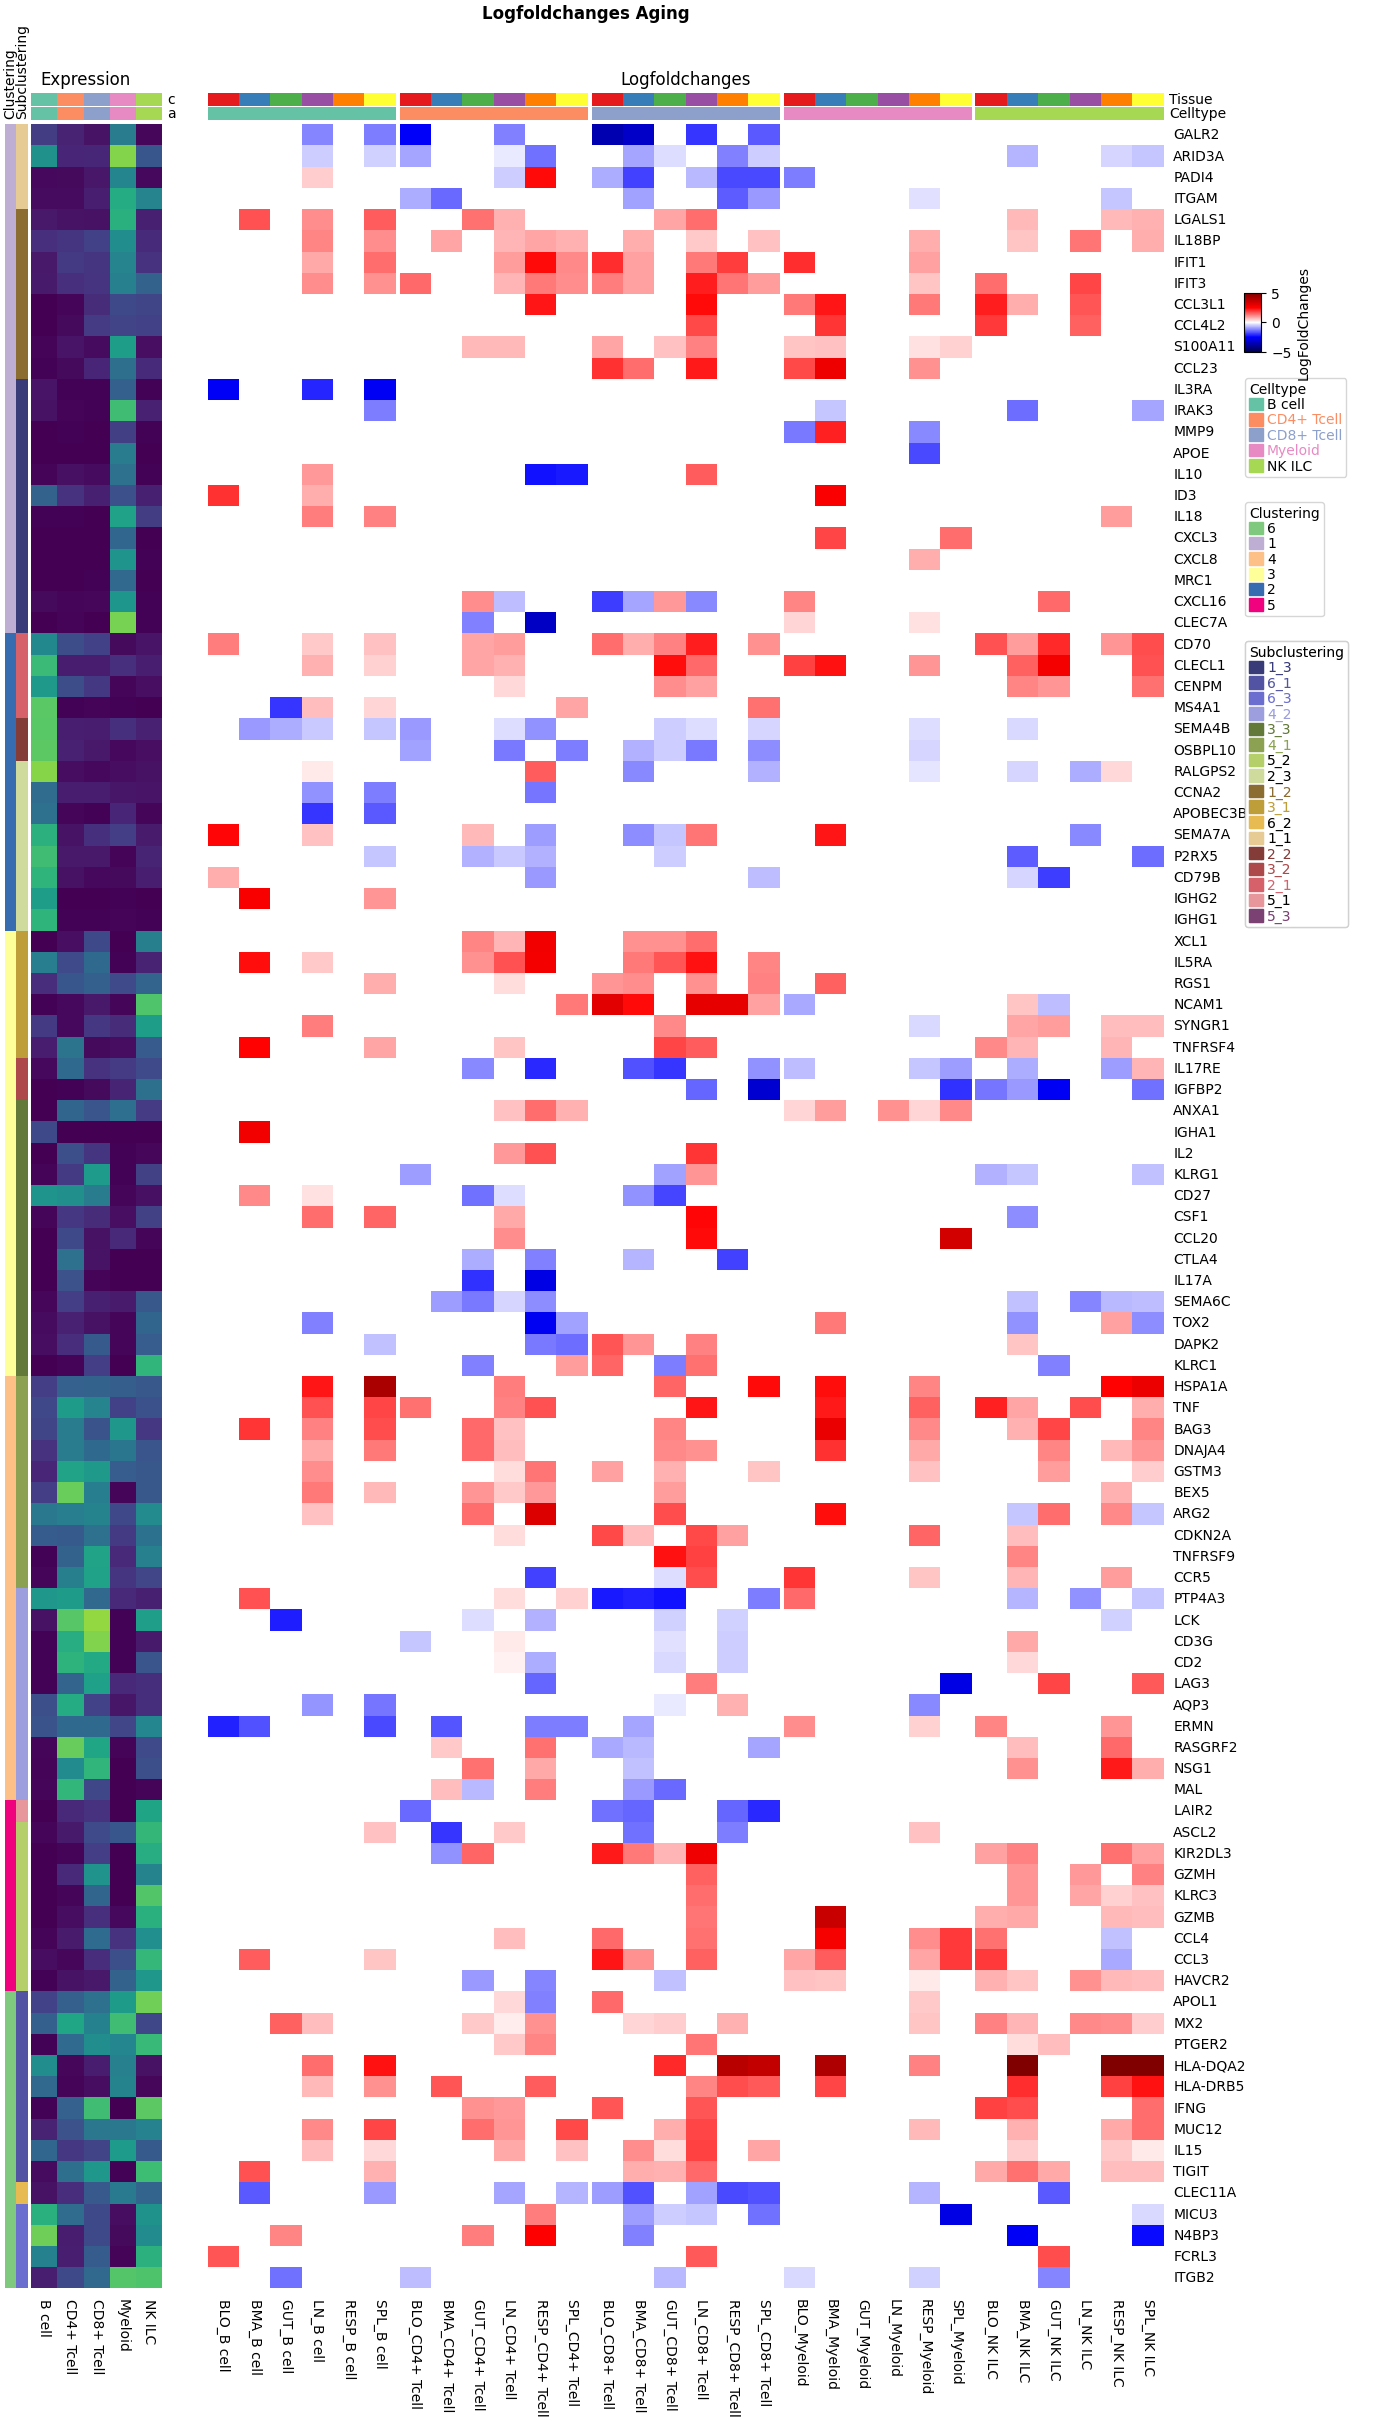

In [1266]:
df_plot_norm = df_plot_norm.loc[gene_order_sub]

# Split column names
columns_split = df_plot_norm.columns.str.split('_', expand=True)
str2_values = [i[1] for i in columns_split]

# Group by STR2 and compute the mean
ct_mean_expression = df_plot_norm.groupby(str2_values, axis=1).mean()

sorted_cols = sorted(df_plot.columns, key=lambda x: (x[0]))
df_plot = df_plot[sorted_cols]

donor_info = pd.DataFrame(columns=['celltype'], index=ct_mean_expression.columns)
donor_info['celltype'] = ct_mean_expression.columns
    
col_ha = complex_heat.HeatmapAnnotation(
    c=complex_heat.anno_simple(donor_info['celltype'],cmap='Set2',rasterized=True, legend=False),
    a=complex_heat.anno_simple(donor_info['celltype'],cmap='Set2',rasterized=True, legend=False),
    axis=1
)

row_ha = complex_heat.HeatmapAnnotation(
    Clustering=complex_heat.anno_simple(clustering['clusters'],cmap='Accent',rasterized=True),
    Subclustering=complex_heat.anno_simple(clustering['subclusters'],cmap='tab20b',rasterized=True),
    axis=0
)

mean_expression = complex_heat.ClusterMapPlotter(
    data=ct_mean_expression, left_annotation=row_ha, top_annotation=col_ha, legend_anchor='ax_heatmap', legend_vpad=20,
    z_score=None,
    row_cluster=False, col_cluster=False,
    rasterized=False, legend=False,
    cmap='viridis',
    show_rownames=False, show_colnames=True,
    col_split_gap=1,row_split_gap=1,
    vmax=1, plot=False, label='Mean Expression'
)

df_plot_lfc = df.pivot(index='assay_group', columns='ID', values='masked_logFC')[list(df_plot_norm.index)].T
#df_plot_lfc.fillna(0, inplace=True)
df_plot_lfc = df_plot_lfc.loc[gene_order_sub]

col_split = [col.split('_') for col in df_plot_lfc.columns]
# Sort by STRING2 and then by STRING1
sorted_cols = sorted(col_split, key=lambda x: (x[1], x[0]))
df_plot_lfc = df_plot_lfc[['_'.join(col) for col in sorted_cols]]

donor_info = pd.DataFrame(columns=['tissue', 'celltype'], index=df_plot_lfc.columns)
donor_info['tissue'] = [i.split('_')[0] for i in df_plot_lfc.columns]
donor_info['celltype'] = [i.split('_')[1] for i in df_plot_lfc.columns]
    
col_ha = complex_heat.HeatmapAnnotation(
    Tissue=complex_heat.anno_simple(donor_info['tissue'],cmap='Set1',rasterized=True, legend=False),
    Celltype=complex_heat.anno_simple(donor_info['celltype'],cmap='Set2',rasterized=True, legend=True),
    axis=1
)

row_ha = complex_heat.HeatmapAnnotation(
    Clustering=complex_heat.anno_simple(clustering['clusters'],cmap='Accent',rasterized=True),
    Subclustering=complex_heat.anno_simple(clustering['subclusters'],cmap='tab20b',rasterized=True),
    axis=0
)
    
plt.figure(figsize=(16, 16))

cm = complex_heat.ClusterMapPlotter(
    data=df_plot_lfc, left_annotation=None, top_annotation=col_ha, legend_anchor='ax_heatmap', legend_vpad=20,
    z_score=None,
    row_cluster=False, col_cluster=False,
    col_split=donor_info['celltype'], #row_split=clustering['clusters'],
    rasterized=False, legend=True,
    cmap='seismic',
    show_rownames=True, show_colnames=True,
    col_split_gap=1,row_split_gap=1,
    vmax=5, vmin=-5, plot=False, label='LogFoldChanges',
)

cmlist=[mean_expression, cm]

plt.figure(figsize=(15,25))
ax,legend_axes=complex_heat.composite(cmlist=cmlist, main=0, legend_hpad=50, col_gap=10)
mean_expression.ax.set_title("Expression")
cm.ax.set_title("Logfoldchanges")
ax.set_title("Logfoldchanges Aging",y=1.03,fontdict={'fontweight':'bold','color':'black'})
plt.savefig("logfoldchanges_aging_sub.pdf", bbox_inches='tight')
plt.show()

In [1332]:
df[df['ID']=='IGHG1']

,Unnamed: 0,assay,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B,z.std,tissue_groups,assay_group,mean_expression,mean_expression_normalized,masked_logFC
RESP_NK ILC_IGHG1,12571,NK ILC,IGHG1,1.177424,2.099303,2.160749,0.032142,0.142764,-3.954028,2.142639,resp,RESP_NK ILC,0.071209,0.004131,NaN
RESP_CD4+ Tcell_IGHG1,28784,CD4+ Tcell,IGHG1,-0.782322,1.640076,-0.896673,0.371155,0.719938,-6.085612,-0.894312,resp,RESP_CD4+ Tcell,0.047504,0.002756,NaN
RESP_Myeloid_IGHG1,31428,Myeloid,IGHG1,0.204355,2.019311,0.767286,0.444150,0.789092,-6.423926,0.765203,resp,RESP_Myeloid,0.047691,0.002766,NaN
RESP_CD8+ Tcell_IGHG1,35474,CD8+ Tcell,IGHG1,-0.690905,1.695931,-0.593835,0.553413,0.871071,-5.372687,-0.592653,resp,RESP_CD8+ Tcell,0.063867,0.003705,NaN
RESP_B cell_IGHG1,55076,B cell,IGHG1,-0.036860,9.753210,-0.019839,0.984198,0.997701,-4.627381,-0.019806,resp,RESP_B cell,16.814835,0.975383,NaN
LN_CD4+ Tcell_IGHG1,8908,CD4+ Tcell,IGHG1,0.829307,1.640076,2.871591,0.004621,0.028967,-2.673780,2.832307,ln,LN_CD4+ Tcell,0.067098,0.003892,NaN
LN_CD8+ Tcell_IGHG1,13257,CD8+ Tcell,IGHG1,1.371934,1.695931,2.251630,0.025626,0.107931,-3.877261,2.231836,ln,LN_CD8+ Tcell,0.068277,0.003961,NaN
LN_NK ILC_IGHG1,21111,NK ILC,IGHG1,-1.688332,2.099303,-1.511635,0.132523,0.350508,-4.575938,-1.504225,ln,LN_NK ILC,0.058196,0.003376,NaN
LN_B cell_IGHG1,27664,B cell,IGHG1,-0.344285,9.753210,-1.073111,0.284944,0.575120,-6.062282,-1.069280,ln,LN_B cell,4.920958,0.285451,NaN
LN_Myeloid_IGHG1,49859,Myeloid,IGHG1,0.317027,2.019311,0.173754,0.862299,0.965670,-4.620023,0.173448,ln,LN_Myeloid,0.427554,0.024801,NaN


In [1105]:
df['masked_logFC_expression'] = df['logFC']
df.loc[np.logical_or(df['P.Value']>0.3, df['mean_expression_normalized']<0.05), 'masked_logFC_expression'] = None

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..


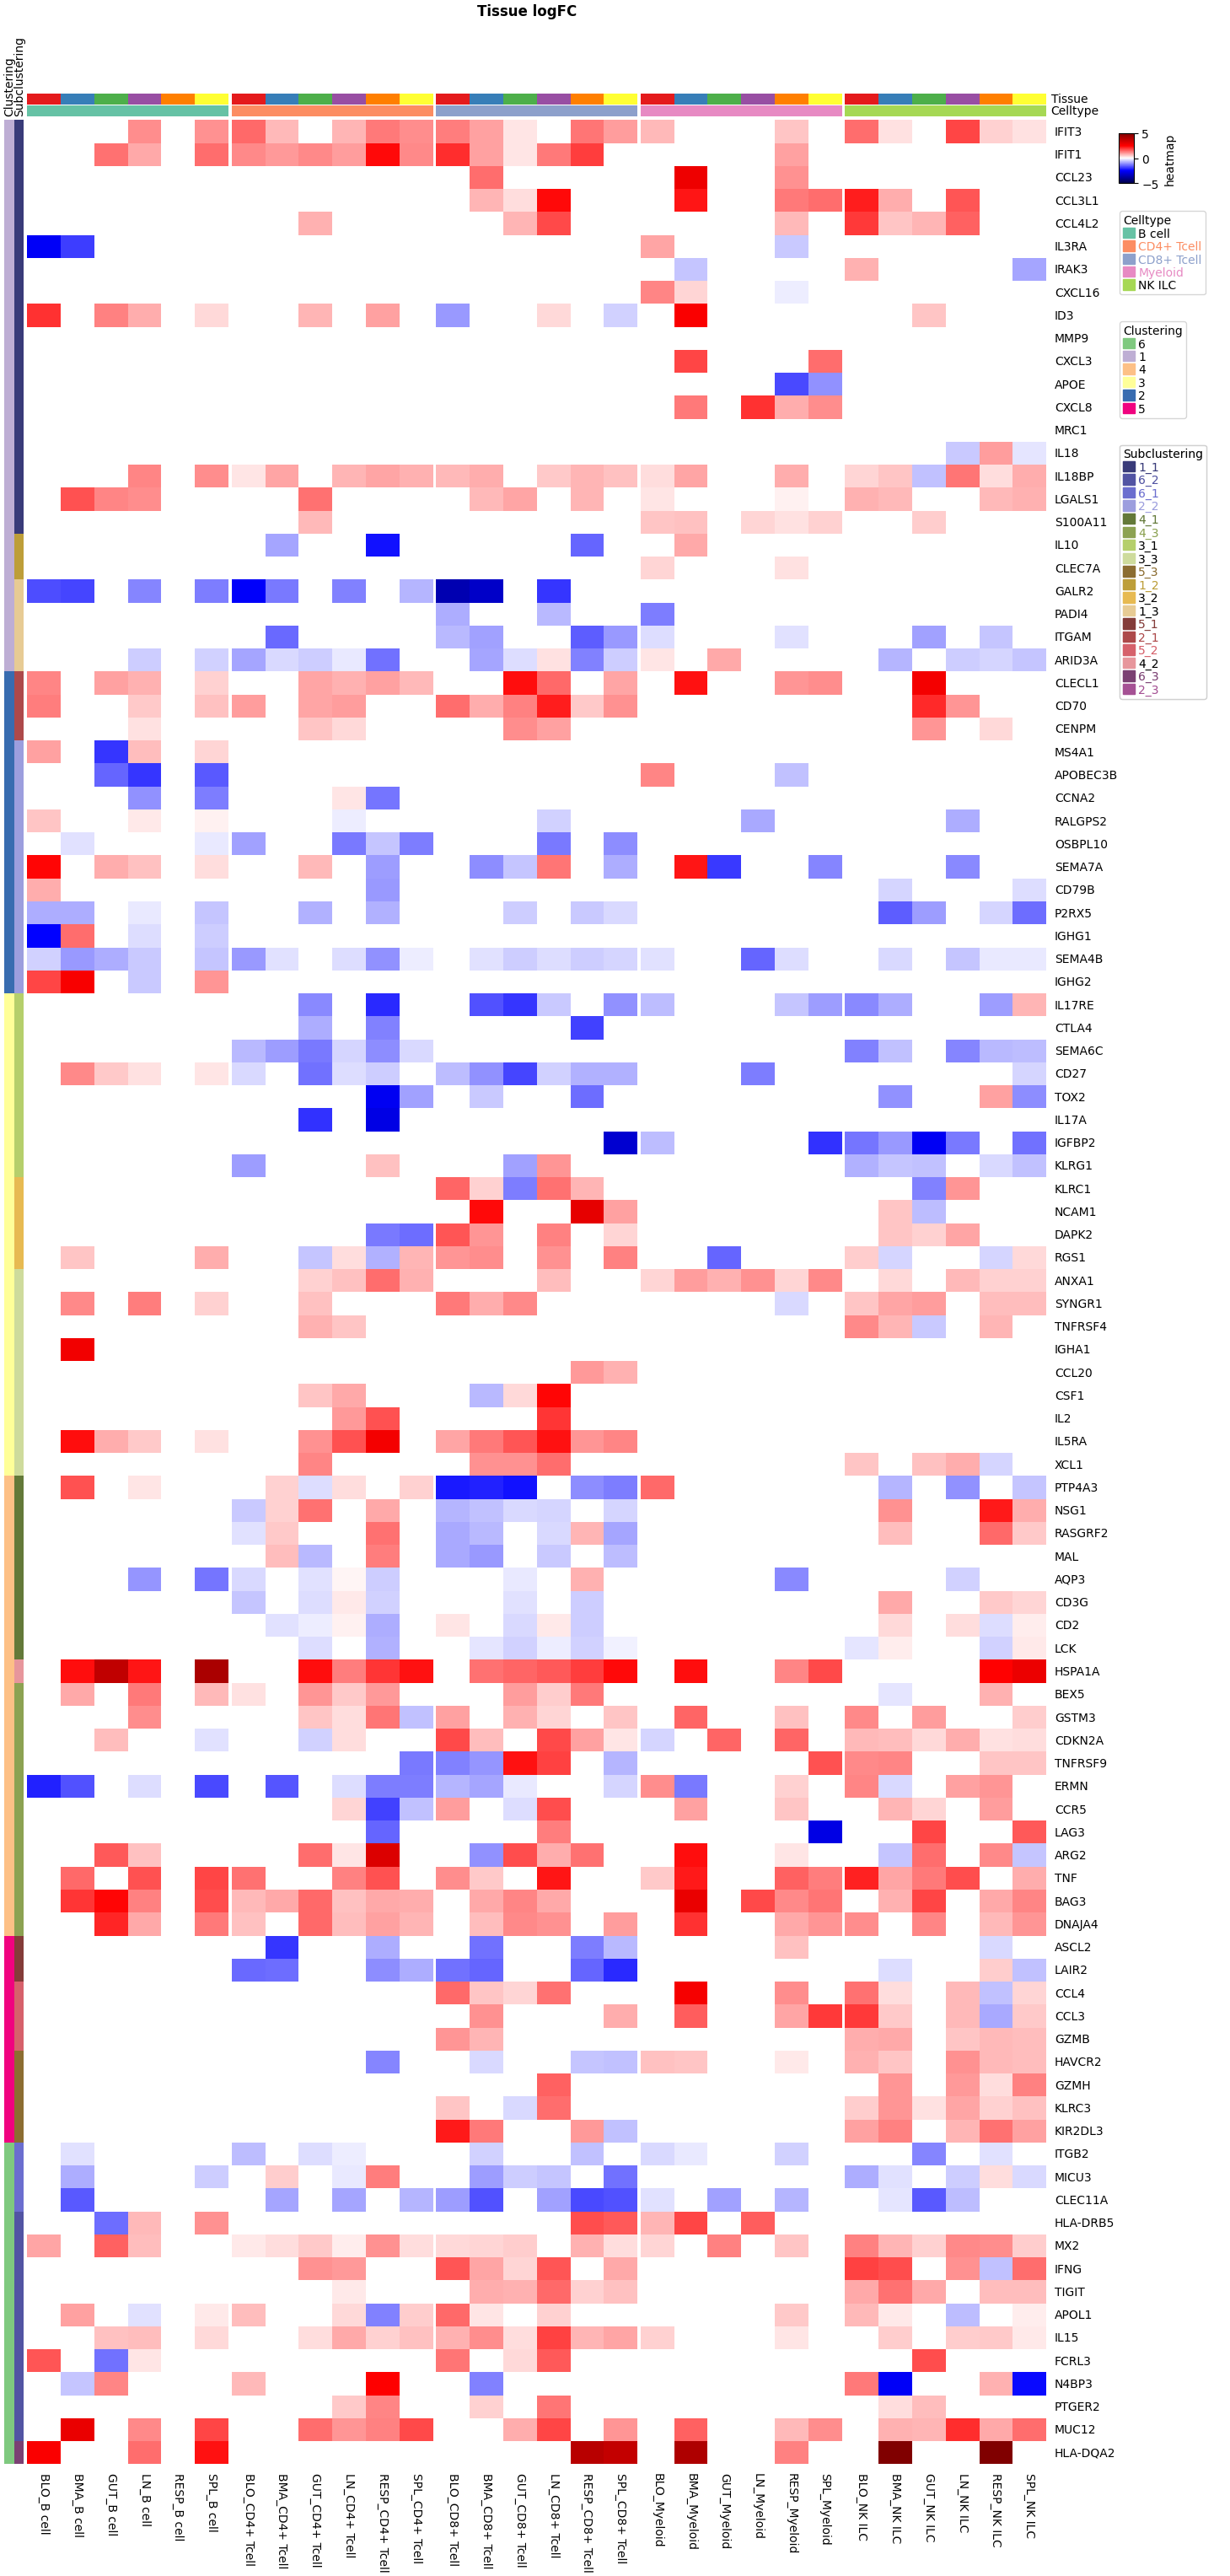

In [1106]:
df_plot_lfc = df.pivot(index='assay_group', columns='ID', values='masked_logFC_expression')[list(df_plot_norm.index)].T
#df_plot_lfc.fillna(0, inplace=True)
df_plot_lfc = df_plot_lfc.loc[gene_order_sub]

col_split = [col.split('_') for col in df_plot_lfc.columns]
# Sort by STRING2 and then by STRING1
sorted_cols = sorted(col_split, key=lambda x: (x[1], x[0]))
df_plot_lfc = df_plot_lfc[['_'.join(col) for col in sorted_cols]]

donor_info = pd.DataFrame(columns=['tissue', 'celltype'], index=df_plot_lfc.columns)
donor_info['tissue'] = [i.split('_')[0] for i in df_plot_lfc.columns]
donor_info['celltype'] = [i.split('_')[1] for i in df_plot_lfc.columns]
    
col_ha = complex_heat.HeatmapAnnotation(
    Tissue=complex_heat.anno_simple(donor_info['tissue'],cmap='Set1',rasterized=True, legend=False),
    Celltype=complex_heat.anno_simple(donor_info['celltype'],cmap='Set2',rasterized=True, legend=True),
    axis=1
)

row_ha = complex_heat.HeatmapAnnotation(
    Clustering=complex_heat.anno_simple(clustering['clusters'],cmap='Accent',rasterized=True),
    Subclustering=complex_heat.anno_simple(clustering['subclusters'],cmap='tab20b',rasterized=True),
    axis=0
)
    
plt.figure(figsize=(16, 32))
cm = complex_heat.ClusterMapPlotter(
    data=df_plot_lfc, left_annotation=row_ha, top_annotation=col_ha, legend_anchor='ax_heatmap', legend_vpad=5,
    z_score=None,
    row_cluster=False, col_cluster=False,
    col_split=donor_info['celltype'], #row_split=clustering['clusters'],
    rasterized=False, legend=True,
    cmap='seismic',
    show_rownames=True, show_colnames=True,
    col_split_gap=1,row_split_gap=1,
    vmax=5, vmin=-5
)
cm.ax.set_title('Tissue logFC',y=1.03,fontdict={'fontweight':'bold'})
plt.savefig("clustermap_tissue_up_sub.pdf", bbox_inches='tight')
plt.show()

In [1162]:
df_merged = df.merge(clustering, on='ID', how='left')


In [1165]:
df_merged.to_csv('de_results_aging.csv') 
df_merged.to_parquet('de_results_aging.gzip', compression='gzip')

In [1166]:
df = pd.DataFrame()
for tissue_group in tissue_groups:
    df_tissue = pd.read_csv(f"results_dreamlet_fine/aging_{tissue_group}_age_random.csv")
    df_tissue["tissue_groups"] = tissue_group
    df = pd.concat([df, df_tissue], axis=0)
df = df.loc[~df['assay'].str.contains('Mast')]

In [1170]:
df.to_csv('de_results_aging_fine.csv') 
df.to_parquet('de_results_aging_fine.gzip', compression='gzip')

In [1323]:
df_merged_sub = df_merged[~df_merged['subclusters'].isna()]
df_merged_sub.to_csv('de_results_aging_all_significant.csv') 

In [1326]:
df_merged_sub_pivot = df_merged_sub.pivot(index='assay_group', columns='ID', values='masked_logFC_expression').T
df_merged_sub.to_csv('de_results_aging_all_significant_lfcs_only.csv') 